# DeafAbraxas - Euro/Usd

**IMPORTANT : to avoid data leakage**

**1. Training Dataset:**

This is the main dataset used to train your machine learning model.
It contains the majority of your data and is used to learn the patterns, relationships, and parameters of the model.
The model is iteratively updated based on the training data to minimize the training error.

**2. Validation Dataset:**

The validation dataset is a subset of the training dataset that is used to tune the model's hyperparameters and assess its performance during the training process.
It acts as an intermediate evaluation set to help you make decisions about model selection, hyperparameter tuning, and early stopping.
The model is not directly trained on the validation data, but it is used to monitor the model's performance on unseen data and prevent overfitting.
You can use techniques like cross-validation to create multiple validation sets from the training data and get a more robust estimate of the model's performance.

**3. Test Dataset:**

The test dataset is a completely independent dataset that is used to evaluate the final performance of your trained model.
It should not be used during the training or validation process and should only be used once the model is fully trained and finalized.
The test dataset provides an unbiased estimate of how well your model generalizes to new, unseen data.
It helps assess the model's performance metrics, such as accuracy, precision, recall, or F1-score, on data that the model has never encountered before.

**4. Conformal Dataset:**

The conformal dataset is a separate dataset used specifically for conformal prediction, which is a technique for quantifying the uncertainty of predictions made by machine learning models.
It is used to calibrate the model's predictions and provide confidence measures or prediction intervals.
The conformal dataset should be representative of the data the model will encounter in real-world scenarios and should be independent of the training, validation, and test datasets.

*By splitting your data into these separate subsets, you can effectively train, validate, and evaluate your machine learning model while minimizing the risk of overfitting and obtaining reliable performance estimates.*

**Here's a general workflow using these datasets:**

- Split your original data into training, test, and conformal datasets.

- Perform EDA, feature engineering, and model selection using only the training dataset.

- Further split the training dataset into training and validation subsets, or use cross-validation techniques to create multiple validation sets.

- Train your model on the training subset and tune hyperparameters using the validation subset.

- Evaluate the final model's performance on the independent test dataset to assess its generalization ability.

- Use the conformal dataset to calibrate the model's predictions and obtain confidence measures or prediction intervals.

Remember to maintain the independence of each dataset throughout the modeling process to ensure unbiased evaluation and reliable performance estimates.




In [9]:
! pip install eli5

In [10]:
# prompt: check skikit-learn, python and other versions

import sklearn
import platform
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid # Import ParameterGrid
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("Python version:", platform.python_version())
print("Scikit-learn version:", sklearn.__version__)

# You can also check other versions depending on your needs, such as:

# TensorFlow version:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Keras version:
import keras
print("Keras version:", keras.__version__)

# Pandas version:
import pandas as pd
print("Pandas version:", pd.__version__)

# Numpy version:
import numpy as np
print("Numpy version:", np.__version__)


Python version: 3.10.12
Scikit-learn version: 1.2.2
TensorFlow version: 2.15.0
Keras version: 2.15.0
Pandas version: 2.0.3
Numpy version: 1.25.2


In [211]:
data = pd.read_csv('/content/drive/MyDrive/DeafAbraxas/data/30m/EURUSD_30M.csv',delimiter=",",header=0,low_memory=False)
print(data.shape)

(67270, 8)


In [212]:
#convert datatime to_datetime
data.rename(columns={"time": "datetime"}, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])

In [213]:
data = data.drop(columns=['real_volume'], axis=1)
print(data.shape)

(67270, 7)


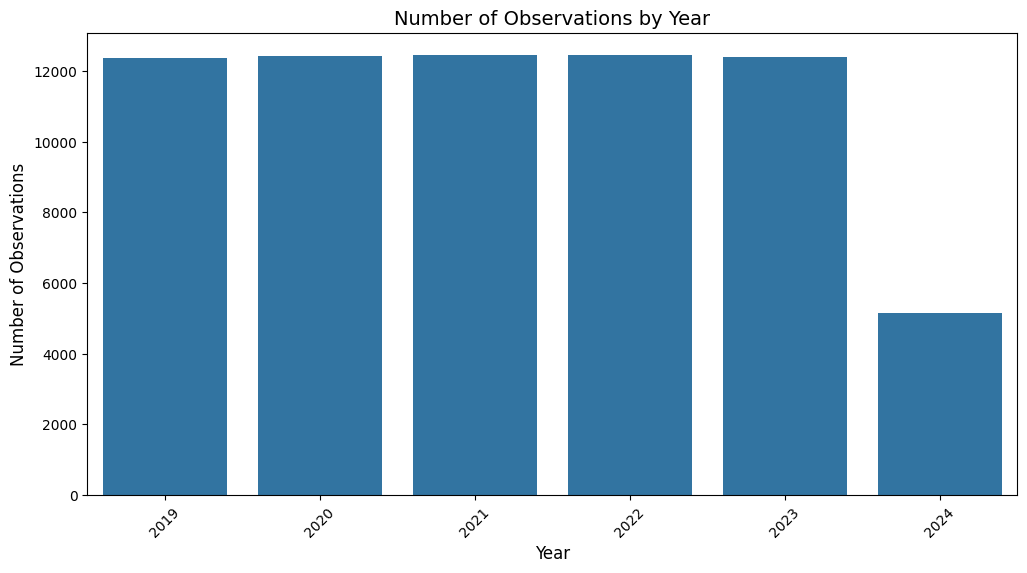

In [214]:
# prompt: create bar plot of number of observations by year in data

import matplotlib.pyplot as plt

# Extract year from datetime column
data["year"] = data["datetime"].dt.year

# Group data by year and count the number of observations
year_counts = data.groupby("year").size()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=year_counts.index, y=year_counts.values)

# Add labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Observations", fontsize=12)
plt.title("Number of Observations by Year", fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Split Data

In [215]:
initial_train_dataset_ = data[(data['datetime'] >= '2019-01-04 01:30:00') & (data['datetime'] <= '2022-06-30 23:30:00')]
initial_validation_dataset_ = data[(data['datetime'] > '2022-06-30 23:30:00') & (data['datetime'] <= '2023-06-30 23:30:00')]
non_seen_test_data = data[(data['datetime'] > '2023-06-30 23:30:00') & (data['datetime'] <= '2023-12-30 23:30:00')]
conformal_dataset_ = data[(data['datetime'] > '2023-12-30 23:30:00')]

In [216]:
print(initial_train_dataset_.shape)
print(initial_validation_dataset_.shape)
print(non_seen_test_data.shape)
print(conformal_dataset_.shape)

(43359, 8)
(12502, 8)
(6170, 8)
(5160, 8)


<ipython-input-154-d8f4dde740db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_train_dataset_["year"] = initial_train_dataset_["datetime"].dt.year


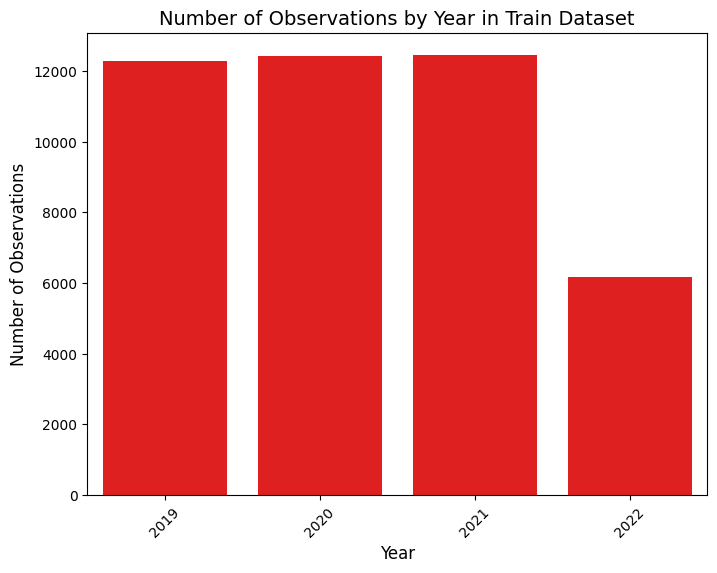

In [154]:
# prompt: bar plot of number of observations by year in train_dataset_ and add some color

# Extract year from datetime column
initial_train_dataset_["year"] = initial_train_dataset_["datetime"].dt.year

# Group data by year and count the number of observations
year_counts = initial_train_dataset_.groupby("year").size()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, color="red")

# Add labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Observations", fontsize=12)
plt.title("Number of Observations by Year in Train Dataset", fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


<ipython-input-155-eafa757dac9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_validation_dataset_["year"] = initial_validation_dataset_["datetime"].dt.year


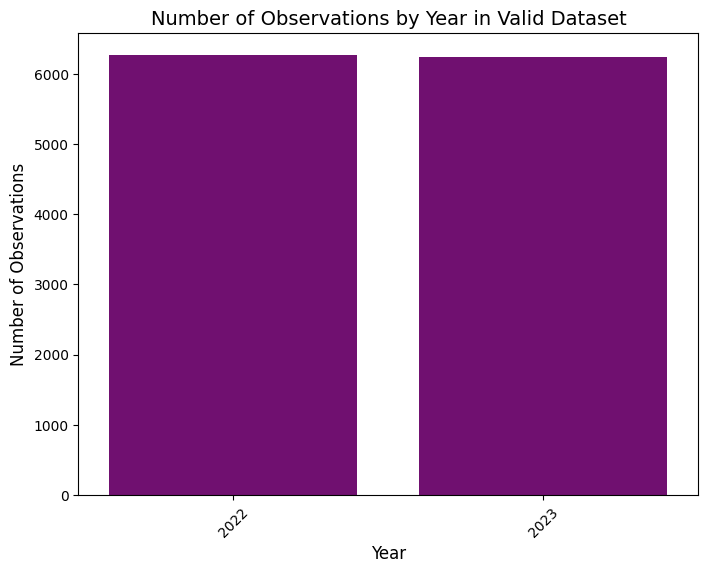

In [155]:
# prompt: bar plot of number of observations by year in validation_dataset_ and add some color

# Extract year from datetime column
initial_validation_dataset_["year"] = initial_validation_dataset_["datetime"].dt.year

# Group data by year and count the number of observations
year_counts = initial_validation_dataset_.groupby("year").size()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, color="purple")

# Add labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Observations", fontsize=12)
plt.title("Number of Observations by Year in Valid Dataset", fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Targets to test

## 1. Multi-Class Classification Target:

Create a multi-class target column that categorizes the pip change into different ranges.

In [156]:
df = initial_train_dataset_.copy()
df_val = initial_validation_dataset_.copy()
print(df.shape)
print(df_val.shape)

(43359, 8)
(12502, 8)


In [157]:
# Calculate the pip changes
pip_changes = (df['close'].shift(-1) - df['close']) * 10000
#df.dropna(inplace=True)

In [158]:
df.head()

,datetime,open,high,low,close,tick_volume,spread,year
79,2019-01-04 01:30:00,1.13939,1.13963,1.13896,1.13899,614,2,2019
80,2019-01-04 02:00:00,1.13900,1.13975,1.13892,1.13967,1579,2,2019
81,2019-01-04 02:30:00,1.13969,1.14053,1.13960,1.14052,980,2,2019
82,2019-01-04 03:00:00,1.14052,1.14116,1.14042,1.14088,928,2,2019
83,2019-01-04 03:30:00,1.14087,1.14101,1.14027,1.14039,1055,2,2019


In [159]:
#basic statistics
pip_changes.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    43358.000000
mean        -0.020912
std          7.089366
min       -123.900000
25%         -3.000000
50%          0.000000
75%          3.000000
90%          6.900000
95%         10.300000
99%         19.900000
max         89.300000
Name: close, dtype: float64

# EDA - Training Data set

In [160]:
pip_ranges = [-np.inf ,-3.0, 3.0, np.inf]
df['target_multiclass'] = pd.cut((df['close'].shift(-1) - df['close']) * 10000, bins=pip_ranges, labels=False)

<ipython-input-161-a0f1d133c134>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=df, palette='hls')


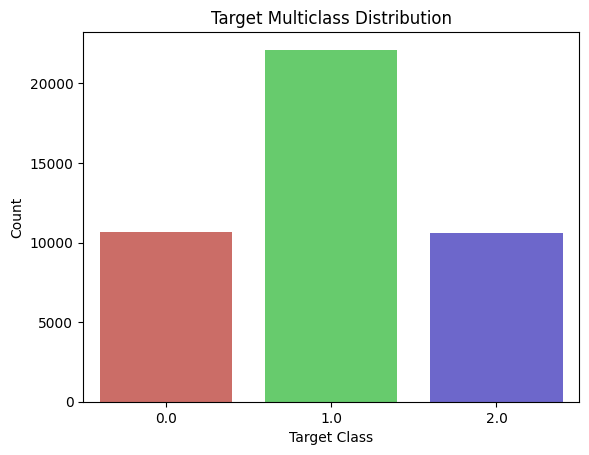

In [161]:
# prompt: plot target_multiclass distribution add colors

import matplotlib.pyplot as plt
import seaborn as sns

# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=df, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()


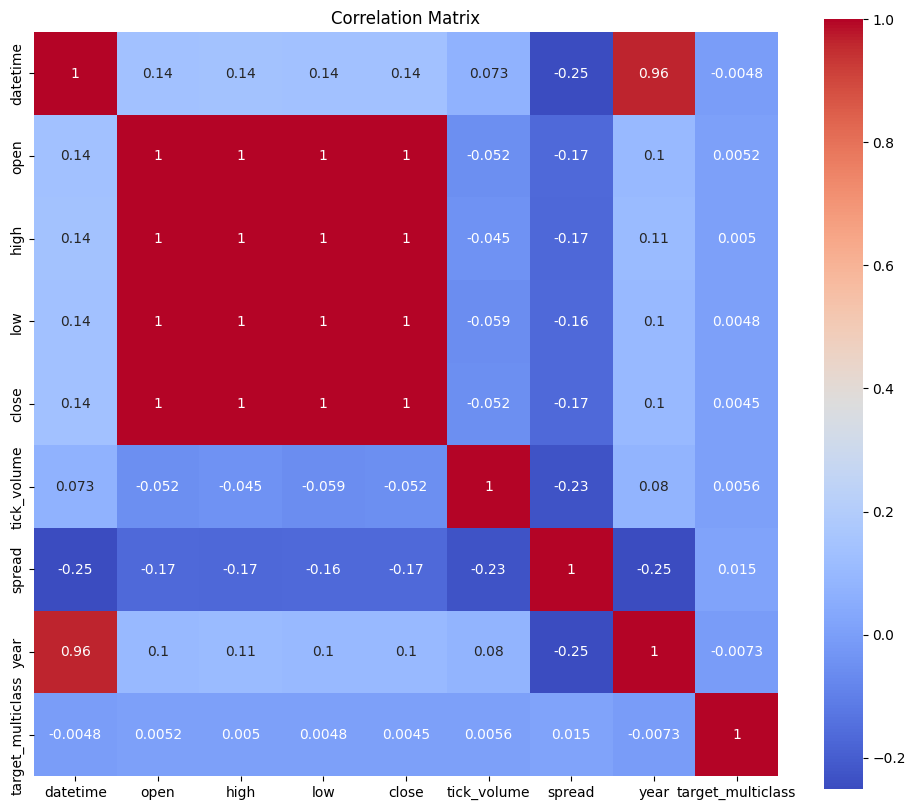

In [162]:
# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Feature Engineering Training dataset

## Economic features

In [163]:
def get_event_category(timestamp):
    # Convert the timestamp to the desired time zone (e.g., GMT)
    timestamp = timestamp.tz_localize('UTC').tz_convert('GMT')

    # Check if the timestamp falls within the ECB Monetary Policy Decisions
    if timestamp.weekday() == 3 and timestamp.hour == 12 and timestamp.minute == 45: #for data base with 15 minutes separation
        return 1

    # Check if the timestamp falls within the U.S. Economic Releases
    elif timestamp.weekday() == 4 and timestamp.hour == 12 and timestamp.minute == 30:
        return 2

    # Check if the timestamp falls within the European Economic Releases
    elif timestamp.hour == 10 and timestamp.minute == 0:
        return 3

    # Check if the timestamp falls within the Overlap of U.S. and European Trading Sessions
    elif timestamp.hour >= 12 and timestamp.hour < 16:
        return 4

    # If the timestamp doesn't fall within any specific category, assign it to the "others" category
    else:
        return 5

In [164]:
df['event_category'] = df['datetime'].apply(get_event_category)
print(df.shape)

(43359, 10)


In [165]:
event_dummies = pd.get_dummies(df['event_category'], prefix='event', dtype=int)
df = pd.concat([df, event_dummies], axis=1)
print(df.shape)

(43359, 14)


In [166]:
# prompt: count different values in even_2, event_3, event_4 and even_5

event_2_counts = df['event_2'].value_counts()
event_3_counts = df['event_3'].value_counts()
event_4_counts = df['event_4'].value_counts()
event_5_counts = df['event_5'].value_counts()

print("Event 2 counts:\n", event_2_counts)
print("Event 3 counts:\n", event_3_counts)
print("Event 4 counts:\n", event_4_counts)
print("Event 5 counts:\n", event_5_counts)


Event 2 counts:
 event_2
0    43179
1      180
Name: count, dtype: int64
Event 3 counts:
 event_3
0    42453
1      906
Name: count, dtype: int64
Event 4 counts:
 event_4
0    36291
1     7068
Name: count, dtype: int64
Event 5 counts:
 event_5
1    35205
0     8154
Name: count, dtype: int64


In [167]:
def features_engineering(data):
    # Check if the input is a single row or a DataFrame
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data).T

    # Moving Averages
    data['MA_10'] = data['close'].rolling(window=10).mean()
    data['MA_20'] = data['close'].rolling(window=20).mean()
    data['MA_50'] = data['close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    data['BB_middle'] = data['close'].rolling(window=20).mean()
    data['BB_std'] = data['close'].rolling(window=20).std()
    data['BB_upper'] = data['BB_middle'] + (2 * data['BB_std'])
    data['BB_lower'] = data['BB_middle'] - (2 * data['BB_std'])

    # Momentum
    data['Momentum'] = data['close'] - data['close'].shift(10)

    # Stochastic Oscillator
    data['Stochastic_K'] = ((data['close'] - data['low'].rolling(window=14).min()) /
                            (data['high'].rolling(window=14).max() - data['low'].rolling(window=14).min())) * 100
    data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

    # Lagged Features
    lags = [1, 2, 3, 5, 10]
    for lag in lags:
        data[f'close_lag_{lag}'] = data['close'].shift(lag)
        data[f'volume_lag_{lag}'] = data['tick_volume'].shift(lag)
        data[f'MA_10_lag_{lag}'] = data['MA_10'].shift(lag)
        data[f'RSI_lag_{lag}'] = data['RSI'].shift(lag)
        data[f'BB_middle_lag_{lag}'] = data['BB_middle'].shift(lag)

    # Datetime Features
    #data['hour'] = data.index.hour
    #data['day'] = data.index.day
    #data['month'] = data.index.month
    #data['year'] = data.index.year
    #data['dayofweek'] = data.index.dayofweek

    # Price Change Features
    data['price_change_1'] = data['close'].pct_change(periods=1)
    data['price_change_5'] = data['close'].pct_change(periods=5)
    data['price_change_10'] = data['close'].pct_change(periods=10)

    # Volatility Features
    data['volatility_10'] = data['close'].rolling(window=10).std()
    data['volatility_20'] = data['close'].rolling(window=20).std()
    data['volatility_50'] = data['close'].rolling(window=50).std()

    # Average True Range (ATR)
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    data['ATR'] = ranges.max(axis=1).rolling(window=14).mean()

    # Drop rows with missing values
    data.dropna(inplace=True)

    return data

In [168]:
# Create new features for the entire dataset
featured_data = features_engineering(df)
print(featured_data.shape)

(43309, 57)


# EDA & Feature Engineering Validation dataset

In [170]:
initial_validation_dataset_.head(2)

,datetime,open,high,low,close,tick_volume,spread,year
43438,2022-07-01 00:00:00,1.04831,1.04853,1.04783,1.04849,298,4,2022
43439,2022-07-01 00:30:00,1.04849,1.04850,1.04775,1.04797,237,10,2022


In [171]:
pip_ranges_val = [-np.inf ,-3.0, 3.0, np.inf]
initial_validation_dataset_['target_multiclass'] = pd.cut((initial_validation_dataset_['close'].shift(-1) - initial_validation_dataset_['close']) * 10000, bins=pip_ranges, labels=False)

<ipython-input-171-2a7441da2a0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_validation_dataset_['target_multiclass'] = pd.cut((initial_validation_dataset_['close'].shift(-1) - initial_validation_dataset_['close']) * 10000, bins=pip_ranges, labels=False)


<ipython-input-172-cf3e1a8459a2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=initial_validation_dataset_, palette='hls')


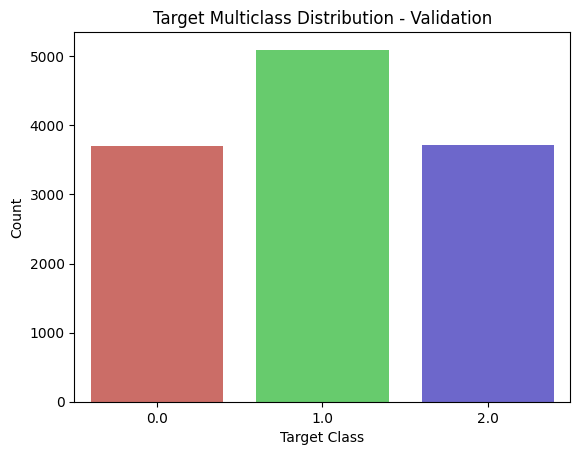

In [172]:
# prompt: plot target_multiclass distribution add colors

# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=initial_validation_dataset_, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution - Validation')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()

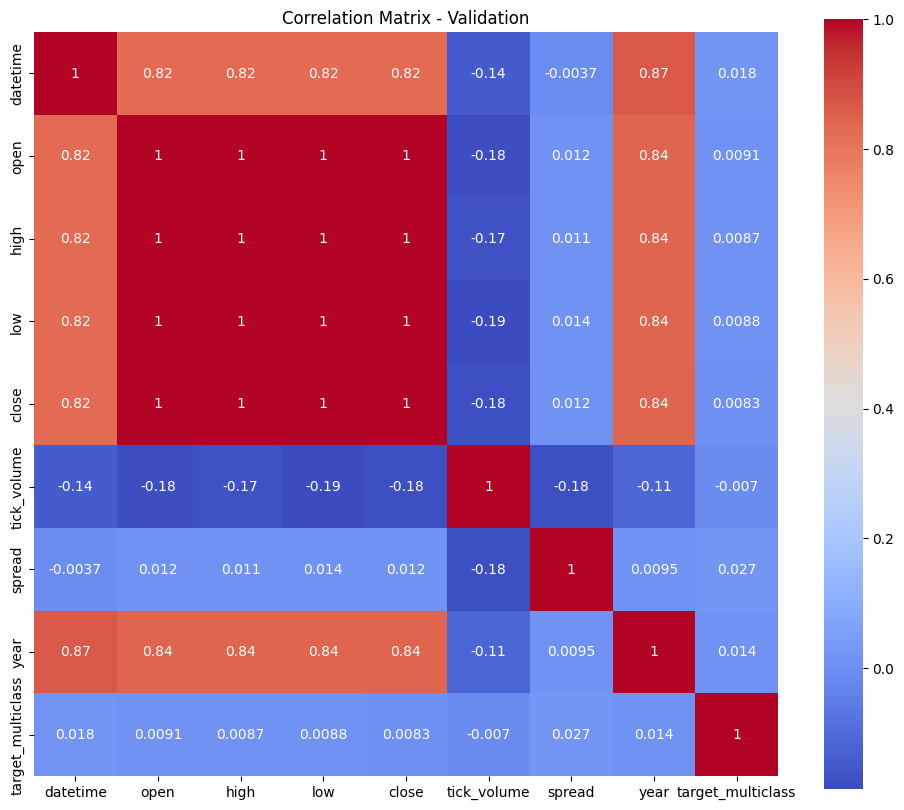

In [173]:
# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix_val = initial_validation_dataset_.corr()
sns.heatmap(corr_matrix_val, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix - Validation')
plt.show()

In [174]:
initial_validation_dataset_['event_category'] = initial_validation_dataset_['datetime'].apply(get_event_category)
print(initial_validation_dataset_.shape)

(12502, 10)


<ipython-input-174-f197f960b80e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_validation_dataset_['event_category'] = initial_validation_dataset_['datetime'].apply(get_event_category)


In [175]:
event_dummies = pd.get_dummies(initial_validation_dataset_['event_category'], prefix='event', dtype=int).copy()
initial_validation_dataset_ = pd.concat([initial_validation_dataset_, event_dummies], axis=1).copy()
print(initial_validation_dataset_.shape)

(12502, 14)


In [176]:
# Create new features for the entire dataset
featured_data_val = features_engineering(initial_validation_dataset_).copy()
print(featured_data_val.shape)

(12452, 57)


# Features Selection

In [127]:
featured_data.columns.to_list()

['datetime',
 'open',
 'high',
 'low',
 'close',
 'tick_volume',
 'spread',
 'year',
 'target_multiclass',
 'event_category',
 'event_2',
 'event_3',
 'event_4',
 'event_5',
 'MA_10',
 'MA_20',
 'MA_50',
 'RSI',
 'BB_middle',
 'BB_std',
 'BB_upper',
 'BB_lower',
 'Momentum',
 'Stochastic_K',
 'Stochastic_D',
 'close_lag_1',
 'volume_lag_1',
 'MA_10_lag_1',
 'RSI_lag_1',
 'BB_middle_lag_1',
 'close_lag_2',
 'volume_lag_2',
 'MA_10_lag_2',
 'RSI_lag_2',
 'BB_middle_lag_2',
 'close_lag_3',
 'volume_lag_3',
 'MA_10_lag_3',
 'RSI_lag_3',
 'BB_middle_lag_3',
 'close_lag_5',
 'volume_lag_5',
 'MA_10_lag_5',
 'RSI_lag_5',
 'BB_middle_lag_5',
 'close_lag_10',
 'volume_lag_10',
 'MA_10_lag_10',
 'RSI_lag_10',
 'BB_middle_lag_10',
 'price_change_1',
 'price_change_5',
 'price_change_10',
 'volatility_10',
 'volatility_20',
 'volatility_50',
 'ATR',
 'noise_normal',
 'noise_uniform']

In [128]:
#Create two additional variables from normal and uniform distributions
# Create noise variables
featured_data['noise_normal'] = np.random.normal(0, 1, len(featured_data))
featured_data['noise_uniform'] = np.random.uniform(0, 1, len(featured_data))

In [129]:
# Define the features (X) and target variable (y)
X = featured_data.drop(['target_multiclass','datetime','close','year'], axis=1)
y = featured_data['target_multiclass']

In [130]:
# Initialize the models
model1 = RandomForestClassifier(random_state=42)
model2 = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000)
model3 = RidgeClassifier(random_state=42)

In [131]:
# Fit the models
model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RidgeClassifier(random_state=42)

In [132]:
# Get feature importances or coefficients
importances1 = model1.feature_importances_
importances2 = model2.coef_
importances3 = model3.coef_

In [133]:
# Set the desired number of top features to select
top_n_features = 30

In [134]:
# Select top features using feature importances or coefficients
selector1 = SelectFromModel(model1, prefit=True, max_features=top_n_features)
selector2 = SelectFromModel(model2, prefit=True, max_features=top_n_features)
selector3 = SelectFromModel(model3, prefit=True, max_features=top_n_features)

In [135]:
# Get the selected features
selected_features1 = selector1.get_support()
selected_features2 = selector2.get_support()
selected_features3 = selector3.get_support()

In [136]:
# Count the votes for each feature
feature_votes = selected_features1.astype(int) + selected_features2.astype(int) + selected_features3.astype(int)

In [137]:
# Set a threshold for the minimum number of votes required
vote_threshold = 2

In [138]:
# Select features with votes above the threshold
selected_features = feature_votes >= vote_threshold

In [139]:
# Get the selected feature names
selected_features_names = X.columns[selected_features]

Text(0.5, 1.0, 'Feature Votes')

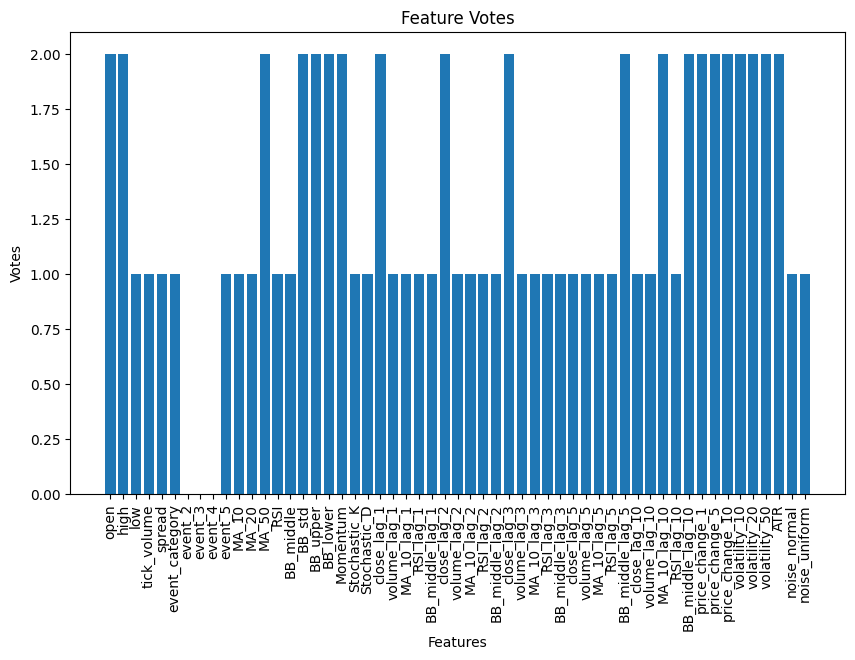

In [140]:
# Create a bar plot of the feature votes
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_votes)), feature_votes, align='center')
plt.xticks(range(len(feature_votes)), X.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Votes')
plt.title('Feature Votes')

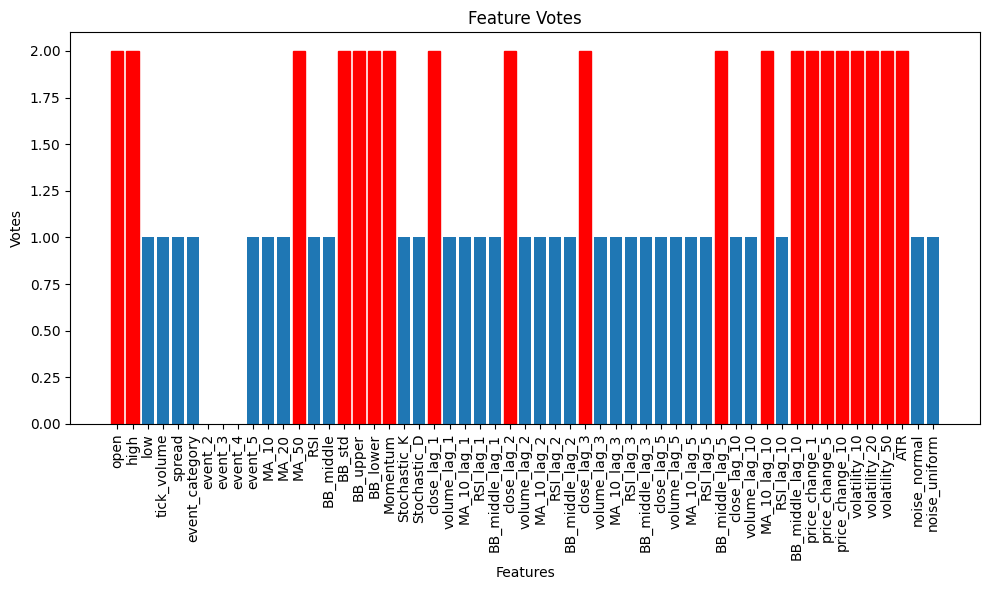

In [141]:
# Create a bar plot of the feature votes
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_votes)), feature_votes, align='center') # Capture the bar objects
plt.xticks(range(len(feature_votes)), X.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Votes')
plt.title('Feature Votes')

# Highlight the selected features
selected_features_indices = [i for i, x in enumerate(selected_features) if x]
if selected_features_indices:
    for i in selected_features_indices:
        if i < len(bars): # Check if index is within bounds
            bars[i].set_color('red') # Access the bar objects directly
else:
    print("No features were selected based on the voting system.")

plt.tight_layout()
plt.show()

In [142]:
# Print the selected feature names
print("Selected Features:")
print(selected_features_names)

Selected Features:
Index(['open', 'high', 'MA_50', 'BB_std', 'BB_upper', 'BB_lower', 'Momentum',
       'close_lag_1', 'close_lag_2', 'close_lag_3', 'BB_middle_lag_5',
       'MA_10_lag_10', 'BB_middle_lag_10', 'price_change_1', 'price_change_5',
       'price_change_10', 'volatility_10', 'volatility_20', 'volatility_50',
       'ATR'],
      dtype='object')


In [ ]:
#selected_features_names = [
#    'open', 'high', 'MA_50', 'BB_std', 'BB_upper', 'BB_lower', 'Momentum',
#       'close_lag_1', 'close_lag_3', 'close_lag_5', 'BB_middle_lag_5',
#       'MA_10_lag_10', 'BB_middle_lag_10', 'price_change_1', 'price_change_5',
#       'price_change_10', 'volatility_10', 'volatility_20', 'volatility_50',
#       'ATR'
#]

- We set the desired number of top features to select using the top_n_features variable. You can adjust this value according to your preference.

- We use SelectFromModel from scikit-learn to select the top features based on the feature importances or coefficients of each model. We set the max_features parameter to top_n_features to limit the number of selected features.

- We get the selected features from each model using selector1.get_support(), selector2.get_support(), and selector3.get_support(). These return boolean masks indicating which features are selected.

- We count the votes for each feature by converting the boolean masks to integers and summing them up. This gives us the number of models that voted for each feature.

- We set a threshold for the minimum number of votes required using the vote_threshold variable. Features with votes equal to or above this threshold will be considered as the final selected features.

- We create a boolean mask selected_features that indicates which features have votes above the threshold.

- We retrieve the names of the selected features using X.columns[selected_features] and print them.

# Lightgbm Model - Class 0

> Añadir blockquote



In [177]:
#create a new dataframe with columns_to_model and add 'DateTime' and 'class' features
df_to_model = featured_data[list(selected_features_names) + ['datetime', 'target_multiclass']] # Convert selected_features_names to a list
print(df_to_model.shape)

(43309, 22)


In [178]:
df_to_model_val = featured_data_val[list(selected_features_names) + ['datetime', 'target_multiclass']] # Convert selected_features_names to a list
print(df_to_model_val.shape)

(12452, 22)


<ipython-input-144-76a274cfe3a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_model['Year'] = pd.to_datetime(df_to_model['datetime']).dt.year
<ipython-input-144-76a274cfe3a0>:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#d62728'` for the same effect.

  sns.countplot(x='Year', hue='target_multiclass', data=df_to_model,color=sns.color_palette()[3])


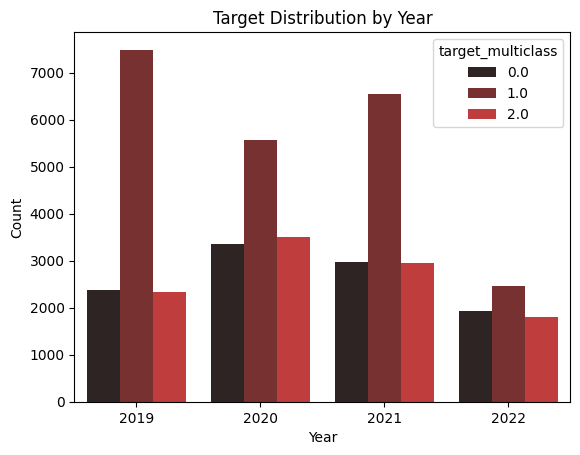

In [144]:
# prompt: plot by year target distribution
# Extract year from DateTime column
df_to_model['Year'] = pd.to_datetime(df_to_model['datetime']).dt.year

# Create a countplot of target by year
sns.countplot(x='Year', hue='target_multiclass', data=df_to_model,color=sns.color_palette()[3])
plt.title('Target Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [145]:
# prompt: count by year the total of every categorie
df_to_model.groupby('Year')['target_multiclass'].value_counts().unstack().fillna(0).astype(int).style.background_gradient(cmap='coolwarm')

target_multiclass,0.000000,1.000000,2.000000
Year,,,
2019,2374,7489,2328
2020,3352,5576,3508
2021,2965,6543,2946
2022,1924,2461,1794


In [179]:
print(df_to_model.datetime.head(1))
print(df_to_model.datetime.tail(1))

128   2019-01-07 02:00:00
Name: datetime, dtype: datetime64[ns]
43436   2022-06-30 23:00:00
Name: datetime, dtype: datetime64[ns]


In [180]:
print(df_to_model_val.datetime.head(1))
print(df_to_model_val.datetime.tail(1))

43487   2022-07-04 00:30:00
Name: datetime, dtype: datetime64[ns]
55938   2023-06-30 23:00:00
Name: datetime, dtype: datetime64[ns]


In [181]:
print(df_to_model.shape)
print(df_to_model_val.shape)

(43309, 22)
(12452, 22)


In [ ]:
#save conformal dataset
#conformal_dataset_.to_csv('/content/drive/MyDrive/DeafAbraxas/data/30m/conformal_dataset.csv',index=False)

In [182]:
#to model
train_dataset_ = df_to_model.copy()
test_dataset_ = df_to_model_val.copy()

In [183]:
##Model configuration
Y_train_cv, X_train_cv = train_dataset_.target_multiclass, train_dataset_
Y_validation, X_validation = test_dataset_.target_multiclass, test_dataset_

In [184]:
X_train_cv_final = X_train_cv[list(selected_features_names)]
X_validation_final = X_validation[list(selected_features_names)]

In [185]:
print(X_train_cv_final.shape)
print(X_validation_final.shape)

(43309, 20)
(12452, 20)


In [186]:
X_train_cv_final.head()

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,BB_middle_lag_5,MA_10_lag_10,BB_middle_lag_10,price_change_1,price_change_5,price_change_10,volatility_10,volatility_20,volatility_50,ATR
128,1.14103,1.14112,1.139933,0.001211,1.142435,1.137589,0.00064,1.14101,1.14074,1.14048,1.139608,1.139781,1.139790,-0.000386,0.001001,0.000561,0.000471,0.001211,0.001188,0.000738
129,1.14057,1.14135,1.139971,0.000533,1.141357,1.139223,0.00093,1.14057,1.14101,1.14074,1.139551,1.140244,1.139776,0.000298,0.000754,0.000816,0.000504,0.000533,0.001188,0.000713
130,1.14092,1.14117,1.140000,0.000493,1.141375,1.139401,0.00098,1.14091,1.14057,1.14101,1.139547,1.140342,1.139765,0.000184,0.000561,0.000860,0.000555,0.000493,0.001198,0.000682
131,1.14112,1.14229,1.140032,0.000609,1.141658,1.139223,0.00183,1.14112,1.14091,1.14057,1.139574,1.140264,1.139758,0.000850,0.001183,0.001605,0.000756,0.000609,0.001232,0.000731
132,1.14210,1.14211,1.140052,0.000685,1.141903,1.139164,0.00215,1.14209,1.14112,1.14091,1.139768,1.140235,1.139694,-0.000149,0.000798,0.001886,0.000793,0.000685,0.001255,0.000700


In [187]:
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Define class_weight
class_weight = {0:1.5, 1: 0.25, 2: 0.5}  # Assign weights

# Initialize a LGBMClassifier with class weights
clf = lgb.LGBMClassifier(class_weight=class_weight)

# Set up possible parameters to randomly sample from
param_test = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(80, 100),
    'max_depth': sp_randint(32, 84),
    'num_leaves': sp_randint(5, 31),
    'min_child_samples': sp_randint(5, 30),
    'min_child_weight': [0.001, 0.005, 0.008],
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0],
    'reg_lambda': [0.1],
    'force_row_wise': [True]
}

# A dictionary of the metrics of interest
scoring = {'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro', 'roc_auc_ovr': 'roc_auc_ovr'}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_test,
                                   n_iter=5, scoring=scoring, cv=tscv, refit='f1_macro',
                                   random_state=314, verbose=True)

# Fit randomized_search. Use X_train_cv_final and Y_train_cv here
random_search.fit(X_train_cv_final, Y_train_cv)

# Get the best parameters from the RandomizedSearchCV and print
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Create a new classifier using the best parameters from the RandomizedSearchCV
clf = lgb.LGBMClassifier(**best_params, class_weight=class_weight)

inner_cv = TimeSeriesSplit(n_splits=8)
outer_cv = TimeSeriesSplit(n_splits=5)

# Nested CV with parameter optimization
nested_score = cross_val_score(clf, X=X_train_cv_final, y=Y_train_cv, cv=outer_cv)
print("Nested CV score: ", nested_score.mean())

# Train a new model on the whole training set using the best parameters found
clf.fit(X_train_cv_final, Y_train_cv)

# Test the trained model on the unseen test set
predictions = clf.predict(X_validation_final)
print(predictions)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 20
[LightGBM] [Info] Start training from score -0.606578
[LightGBM] [Info] Start training from score -1.292575
[LightGBM] [Info] Start training from score -1.713558
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 14437, number of used features: 20
[LightGBM] [Info] Start training from score -0.611021
[LightGBM] [Info] Start training from score -1.267185
[LightGBM] [Info] Start training from score -1.739657
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 21655, number of used features: 20
[LightGBM] [Info] Start training from score -0.545284
[LightGBM] [Info] Start training from score -1.486483
[LightGBM] [Info] Start training from score -1.639092
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points 

In [188]:
print(clf.get_params())

{'boosting_type': 'gbdt', 'class_weight': {0: 1.5, 1: 0.25, 2: 0.5}, 'colsample_bytree': 0.8964130071786556, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 39, 'min_child_samples': 21, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 87, 'n_jobs': None, 'num_leaves': 29, 'objective': None, 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8131008185506245, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_row_wise': True}


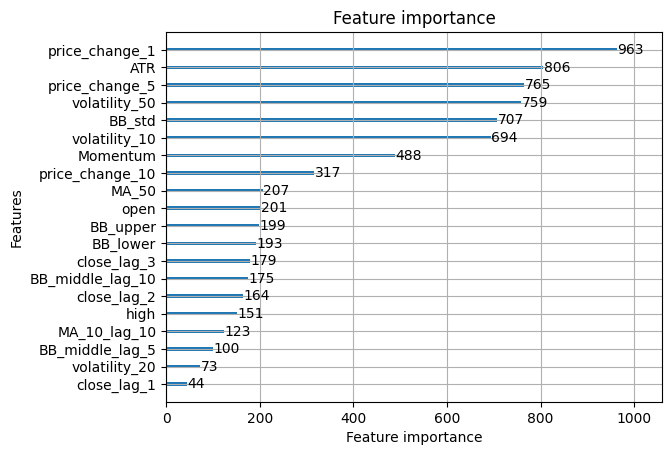

In [189]:
# Assuming bst is your trained LightGBM model
# Plot feature importance
ax = lgb.plot_importance(clf, max_num_features=40, importance_type='split')
plt.show()

In [190]:
# Assuming clf is your trained LightGBM model and X_test, y_test are your test data
# Calculate permutation importance
perm = PermutationImportance(clf, random_state=42).fit(X_validation_final, Y_validation)

In [191]:
# Visualize the feature importances
eli5.show_weights(perm, feature_names=X_validation_final.columns.tolist(), top=40)

Weight,Feature
0.0054 ± 0.0021,ATR
0.0053 ± 0.0017,price_change_1
0.0027 ± 0.0030,price_change_5
0.0015 ± 0.0004,BB_middle_lag_10
0.0015 ± 0.0019,MA_10_lag_10
0.0005 ± 0.0003,BB_lower
0.0003 ± 0.0012,close_lag_2
0.0001 ± 0.0004,close_lag_1
-0.0001 ± 0.0005,BB_middle_lag_5
-0.0001 ± 0.0009,high


In [192]:
#proba & predict
y_test_pred_lg_proba = clf.predict_proba(X_validation_final)
y_test_pred_lg_class = clf.predict(X_validation_final)

In [193]:
#performance

accuracy = accuracy_score(Y_validation, y_test_pred_lg_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 30.87%


<Axes: >

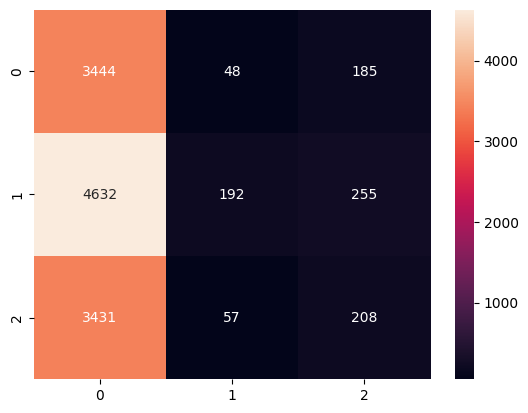

In [194]:
# calculate confusion matrix
cm = confusion_matrix(Y_validation, y_test_pred_lg_class)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

In [195]:
print(classification_report(Y_validation, y_test_pred_lg_class))

              precision    recall  f1-score   support

         0.0       0.30      0.94      0.45      3677
         1.0       0.65      0.04      0.07      5079
         2.0       0.32      0.06      0.10      3696

    accuracy                           0.31     12452
   macro avg       0.42      0.34      0.21     12452
weighted avg       0.45      0.31      0.19     12452



In [196]:
# calculate log loss
logloss = log_loss(Y_validation, y_test_pred_lg_proba)
print("Logloss: %.2f" % logloss)

Logloss: 1.29


In [197]:
# Binarize the output labels
lb = LabelBinarizer()
lb.fit(Y_validation)

binarized_labels = lb.transform(Y_validation)
binarized_predictions = lb.transform(y_test_pred_lg_class)

# Compute and print AUC score
auc = roc_auc_score(binarized_labels, binarized_predictions, multi_class="ovr")
print("AUC: {:.2f}".format(auc))

AUC: 0.51


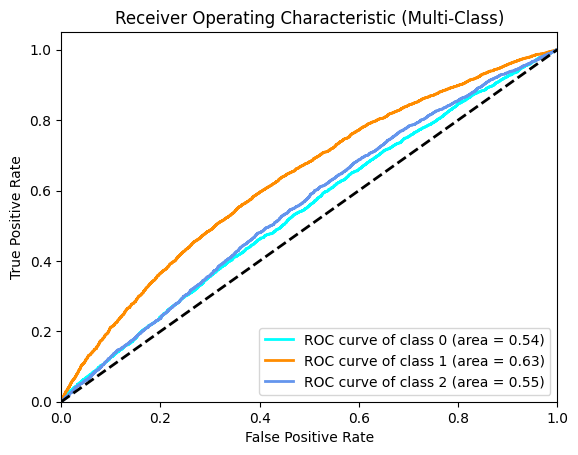

In [198]:
# Assuming Y_validation is your test data's labels and y_test_pred_lg is the predicted probabilities

# Binarize the output
y_test = label_binarize(Y_validation, classes=[0, 1, 2])
n_classes = y_test.shape[1]

y_score = y_test_pred_lg_proba

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    # Use sklearn's auc function directly, avoiding the overwritten variable
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-Class)')
plt.legend(loc="lower right")
plt.show()

In [199]:
result_test_lg=Y_validation.to_frame().copy()
result_test_lg=X_validation.copy()
result_test_lg["datetime"]=X_validation.datetime
result_test_lg["set_type"]='valid'

In [200]:
# prompt: add to result_test_lg the y_test_pred_lg predictions in 4 aditional columns

result_test_lg["class_0"] = y_test_pred_lg_proba[:, 0]
result_test_lg["class_1"] = y_test_pred_lg_proba[:, 1]
result_test_lg["class_2"] = y_test_pred_lg_proba[:, 2]
#result_test_lg["class_3"] = y_test_pred_lg_proba[:, 3]
#result_test_lg["class_4"] = y_test_pred_lg_proba[:, 4]
#result_test_lg["class_5"] = y_test_pred_lg_proba[:, 5]

In [201]:
result_test_lg.tail(50)

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,...,volatility_10,volatility_20,volatility_50,ATR,datetime,target_multiclass,set_type,class_0,class_1,class_2
55889,1.08705,1.08720,1.089995,0.002571,1.094150,1.083868,-0.00205,1.08705,1.08670,1.08720,...,0.000618,0.002571,0.001972,0.001002,2023-06-29 22:30:00,0.0,valid,0.362903,0.450191,0.186906
55890,1.08691,1.08694,1.089890,0.002504,1.093727,1.083710,-0.00222,1.08690,1.08705,1.08670,...,0.000478,0.002504,0.002015,0.000904,2023-06-29 23:00:00,1.0,valid,0.386044,0.438001,0.175956
55891,1.08651,1.08673,1.089789,0.002358,1.093123,1.083692,-0.00150,1.08651,1.08690,1.08705,...,0.000415,0.002358,0.002055,0.000824,2023-06-29 23:30:00,1.0,valid,0.333952,0.481027,0.185022
55892,1.08649,1.08655,1.089695,0.002078,1.092220,1.083906,-0.00138,1.08654,1.08651,1.08690,...,0.000327,0.002078,0.002096,0.000664,2023-06-30 00:00:00,1.0,valid,0.354515,0.457762,0.187723
55893,1.08650,1.08657,1.089595,0.001598,1.090879,1.084488,-0.00079,1.08650,1.08654,1.08651,...,0.000374,0.001598,0.002137,0.000593,2023-06-30 00:30:00,2.0,valid,0.440838,0.353018,0.206144
55894,1.08628,1.08670,1.089502,0.000849,1.089043,1.085647,-0.00068,1.08629,1.08650,1.08654,...,0.000321,0.000849,0.002160,0.000529,2023-06-30 01:00:00,1.0,valid,0.585766,0.241807,0.172427
55895,1.08670,1.08670,1.089407,0.000847,1.088964,1.085575,-0.00066,1.08670,1.08629,1.08650,...,0.000279,0.000847,0.002182,0.000483,2023-06-30 01:30:00,1.0,valid,0.431301,0.410987,0.157713
55896,1.08657,1.08672,1.089309,0.000859,1.088963,1.085525,-0.00059,1.08657,1.08670,1.08629,...,0.000215,0.000859,0.002196,0.000449,2023-06-30 02:00:00,1.0,valid,0.459841,0.421764,0.118395
55897,1.08660,1.08680,1.089216,0.000863,1.088963,1.085511,0.00004,1.08661,1.08657,1.08670,...,0.000217,0.000863,0.002205,0.000399,2023-06-30 02:30:00,1.0,valid,0.424685,0.472484,0.102831
55898,1.08674,1.08686,1.089114,0.000751,1.088608,1.085602,-0.00055,1.08674,1.08661,1.08657,...,0.000165,0.000751,0.002210,0.000394,2023-06-30 03:00:00,2.0,valid,0.434519,0.389769,0.175712


# Evaluate in NoN-Seen Data

In [217]:
non_seen_test_data.shape

(6170, 8)

In [218]:
pip_ranges_test = [-np.inf ,-3.0, 3.0, np.inf]
non_seen_test_data['target_multiclass'] = pd.cut((non_seen_test_data['close'].shift(-1) - non_seen_test_data['close']) * 10000, bins=pip_ranges, labels=False)

<ipython-input-218-44b7f21498b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_seen_test_data['target_multiclass'] = pd.cut((non_seen_test_data['close'].shift(-1) - non_seen_test_data['close']) * 10000, bins=pip_ranges, labels=False)


<ipython-input-219-188d3e7ad818>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=non_seen_test_data, palette='hls')


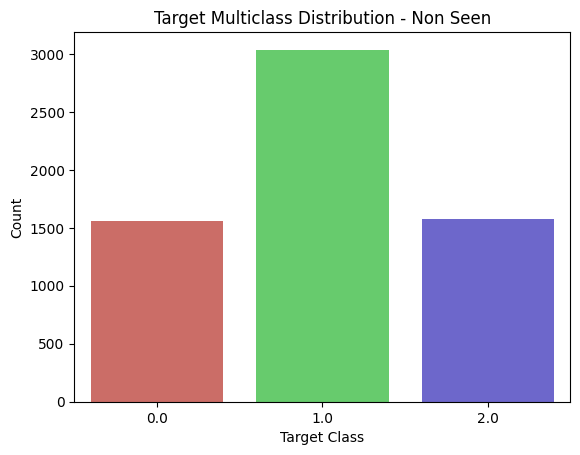

In [219]:
# prompt: plot target_multiclass distribution add colors

# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=non_seen_test_data, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution - Non Seen')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()

In [220]:
# Create new features for the entire dataset
featured_data_test = features_engineering(non_seen_test_data).copy()
print(featured_data_test.shape)

(6120, 52)


<ipython-input-167-c6a7e58dc44a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA_10'] = data['close'].rolling(window=10).mean()
<ipython-input-167-c6a7e58dc44a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA_20'] = data['close'].rolling(window=20).mean()
<ipython-input-167-c6a7e58dc44a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [209]:
#create a new dataframe with columns_to_model and add 'DateTime' and 'class' features
df_to_test = featured_data_test[list(selected_features_names) + ['datetime', 'target_multiclass']] # Convert selected_features_names to a list
print(df_to_test.shape)

(6120, 22)


# Predict NoN-seen Data With Training Model

In [222]:
#proba & predict
y_test_pred_lg_proba_test = clf.predict_proba(df_to_test[list(selected_features_names)])
y_test_pred_lg_class_test = clf.predict(df_to_test[list(selected_features_names)])


In [223]:
#performance
accuracy_test = accuracy_score(df_to_test.target_multiclass, y_test_pred_lg_class_test)
print("Accuracy: %.2f%%" % (accuracy_test * 100.0))

Accuracy: 27.94%


<Axes: >

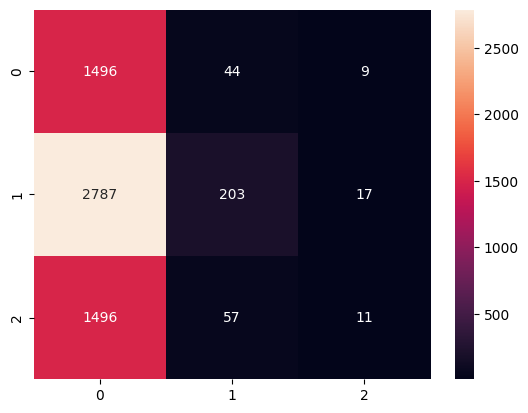

In [224]:
# calculate confusion matrix
cm_test = confusion_matrix(df_to_test.target_multiclass, y_test_pred_lg_class_test)
# plot confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d')

In [225]:
print(classification_report(df_to_test.target_multiclass, y_test_pred_lg_class_test))

              precision    recall  f1-score   support

         0.0       0.26      0.97      0.41      1549
         1.0       0.67      0.07      0.12      3007
         2.0       0.30      0.01      0.01      1564

    accuracy                           0.28      6120
   macro avg       0.41      0.35      0.18      6120
weighted avg       0.47      0.28      0.17      6120



In [226]:
# calculate log loss
logloss_test = log_loss(df_to_test.target_multiclass, y_test_pred_lg_proba_test)
print("Logloss: %.2f" % logloss_test)

Logloss: 1.29


In [227]:
test_lg=df_to_test.target_multiclass.to_frame().copy()
test_lg=df_to_test.copy()
test_lg["datetime"]=df_to_test.datetime
test_lg["set_type"]='test'


In [228]:
test_lg["class_0"] = y_test_pred_lg_proba_test[:, 0]
test_lg["class_1"] = y_test_pred_lg_proba_test[:, 1]
test_lg["class_2"] = y_test_pred_lg_proba_test[:, 2]

In [229]:
test_lg.tail(50)

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,...,volatility_10,volatility_20,volatility_50,ATR,datetime,target_multiclass,set_type,class_0,class_1,class_2
62059,1.10680,1.10706,1.110307,0.002306,1.113298,1.104076,-0.00413,1.10682,1.10647,1.10596,...,0.000593,0.002306,0.002044,0.001276,2023-12-28 22:30:00,0.0,test,0.633966,0.179698,0.186336
62060,1.10655,1.10658,1.110220,0.002220,1.112823,1.103943,-0.00135,1.10655,1.10682,1.10647,...,0.000560,0.002220,0.002129,0.001137,2023-12-28 23:00:00,1.0,test,0.456543,0.280658,0.262798
62061,1.10610,1.10629,1.110132,0.002098,1.112291,1.103898,-0.00097,1.10610,1.10655,1.10682,...,0.000525,0.002098,0.002202,0.001037,2023-12-28 23:30:00,1.0,test,0.503399,0.284427,0.212174
62062,1.10619,1.10633,1.110052,0.001972,1.111777,1.103890,-0.00090,1.10622,1.10610,1.10655,...,0.000464,0.001972,0.002268,0.000964,2023-12-29 00:00:00,1.0,test,0.457849,0.379665,0.162486
62063,1.10628,1.10642,1.109962,0.001830,1.111240,1.103921,-0.00119,1.10629,1.10622,1.10610,...,0.000310,0.001830,0.002330,0.000906,2023-12-29 00:30:00,2.0,test,0.399158,0.376701,0.224141
62064,1.10619,1.10665,1.109891,0.001628,1.110609,1.104096,0.00091,1.10619,1.10629,1.10622,...,0.000263,0.001628,0.002377,0.000707,2023-12-29 01:00:00,1.0,test,0.575834,0.290508,0.133658
62065,1.10665,1.10677,1.109819,0.001633,1.110593,1.104060,0.00036,1.10664,1.10619,1.10629,...,0.000293,0.001633,0.002416,0.000630,2023-12-29 01:30:00,2.0,test,0.495221,0.382489,0.122290
62066,1.10677,1.10731,1.109743,0.001586,1.110407,1.104063,0.00120,1.10677,1.10664,1.10619,...,0.000335,0.001586,0.002439,0.000627,2023-12-29 02:00:00,2.0,test,0.572721,0.295340,0.131938
62067,1.10717,1.10791,1.109679,0.001422,1.109947,1.104260,0.00117,1.10716,1.10677,1.10664,...,0.000485,0.001422,0.002452,0.000650,2023-12-29 02:30:00,2.0,test,0.625515,0.206569,0.167916
62068,1.10764,1.10820,1.109616,0.001067,1.109077,1.104807,0.00118,1.10764,1.10716,1.10677,...,0.000650,0.001067,0.002453,0.000565,2023-12-29 03:00:00,1.0,test,0.616246,0.223100,0.160653


In [230]:
import pickle
filename = 'deaf_abrax_30m_lg_model.sav'
pickle.dump(clf, open(filename, 'wb'))

# LSTM - Class 2

In [231]:
# Step 1: First, import necessary libraries:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [232]:
df_to_model[list(selected_features_names)].head()

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,BB_middle_lag_5,MA_10_lag_10,BB_middle_lag_10,price_change_1,price_change_5,price_change_10,volatility_10,volatility_20,volatility_50,ATR
128,1.14103,1.14112,1.139933,0.001211,1.142435,1.137589,0.00064,1.14101,1.14074,1.14048,1.139608,1.139781,1.139790,-0.000386,0.001001,0.000561,0.000471,0.001211,0.001188,0.000738
129,1.14057,1.14135,1.139971,0.000533,1.141357,1.139223,0.00093,1.14057,1.14101,1.14074,1.139551,1.140244,1.139776,0.000298,0.000754,0.000816,0.000504,0.000533,0.001188,0.000713
130,1.14092,1.14117,1.140000,0.000493,1.141375,1.139401,0.00098,1.14091,1.14057,1.14101,1.139547,1.140342,1.139765,0.000184,0.000561,0.000860,0.000555,0.000493,0.001198,0.000682
131,1.14112,1.14229,1.140032,0.000609,1.141658,1.139223,0.00183,1.14112,1.14091,1.14057,1.139574,1.140264,1.139758,0.000850,0.001183,0.001605,0.000756,0.000609,0.001232,0.000731
132,1.14210,1.14211,1.140052,0.000685,1.141903,1.139164,0.00215,1.14209,1.14112,1.14091,1.139768,1.140235,1.139694,-0.000149,0.000798,0.001886,0.000793,0.000685,0.001255,0.000700


In [233]:
#Step 2: Let's assume your datetime column is named 'date' and your target variable is named 'target'. Drop these columns:
train_dataset = df_to_model[list(selected_features_names)]
test_dataset = df_to_model_val[list(selected_features_names)]

In [234]:
#Step 3: Separating the labels and features:()Assuming 'train_labels'/'test_labels' are your training/testing labels.
# Convert the labels to one-hot encoding
train_labels = to_categorical(df_to_model.target_multiclass)
test_labels = to_categorical(df_to_model_val.target_multiclass)

In [235]:
#Step 4: Prepare the data for LSTM (3D shape):
train_dataset = np.reshape(train_dataset.values, (train_dataset.shape[0], train_dataset.shape[1], 1))
test_dataset = np.reshape(test_dataset.values, (test_dataset.shape[0], test_dataset.shape[1], 1))

In [236]:
print(train_dataset.shape)
print(test_dataset.shape)

(43309, 20, 1)
(12452, 20, 1)


In [237]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [238]:
# Define custom F1-score metric
def f1_m(y_true, y_pred):
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [239]:
# Extract labels from one-hot encoded labels
train_labels_categorical = np.argmax(train_labels, axis=1)
test_labels_categorical = np.argmax(test_labels, axis=1)

In [274]:
def create_model(input_shape):
    model = Sequential()

    # First LSTM layer with BatchNormalization
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Second LSTM layer with BatchNormalization
    model.add(LSTM(100, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Third LSTM layer with BatchNormalization
    model.add(LSTM(80, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Fourth LSTM layer with BatchNormalization
    model.add(LSTM(70))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Dense layer
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    return model

input_shape = (train_dataset.shape[1], 1)
model = create_model(input_shape)

In [275]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True, save_format='h5')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', restore_best_weights=True)
callbacks = [checkpoint, early_stop]

In [276]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_categorical), y=train_labels_categorical)
class_weights[0] *= 0.5  # Increase the weight for class 2
class_weights[1] *= 0.2
class_weights[2] *= 1.5
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [277]:
import keras.backend as K

In [278]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m])
history = model.fit(train_dataset, train_labels, epochs=50, validation_data=(test_dataset, test_labels), callbacks=callbacks, verbose=2, batch_size=64, class_weight=class_weight_dict)

Epoch 1/50
677/677 - 51s - loss: 0.6333 - accuracy: 0.2454 - f1_m: 0.2368 - val_loss: 2.4810 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 51s/epoch - 76ms/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


677/677 - 42s - loss: 0.6077 - accuracy: 0.2446 - f1_m: 0.2441 - val_loss: 2.7953 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 42s/epoch - 62ms/step
Epoch 3/50
677/677 - 42s - loss: 0.6041 - accuracy: 0.2446 - f1_m: 0.2446 - val_loss: 1.6854 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 42s/epoch - 62ms/step
Epoch 4/50
677/677 - 43s - loss: 0.6019 - accuracy: 0.2446 - f1_m: 0.2446 - val_loss: 1.8632 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 43s/epoch - 63ms/step
Epoch 5/50
677/677 - 42s - loss: 0.6000 - accuracy: 0.2446 - f1_m: 0.2446 - val_loss: 1.5775 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 42s/epoch - 62ms/step
Epoch 6/50
677/677 - 42s - loss: 0.5995 - accuracy: 0.2446 - f1_m: 0.2447 - val_loss: 1.5655 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 42s/epoch - 62ms/step
Epoch 7/50
677/677 - 42s - loss: 0.5993 - accuracy: 0.2446 - f1_m: 0.2446 - val_loss: 3.2351 - val_accuracy: 0.2968 - val_f1_m: 0.2970 - 42s/epoch - 62ms/step
Epoch 8/50
677/677 - 42s - loss: 0.5992 - accuracy: 0.244

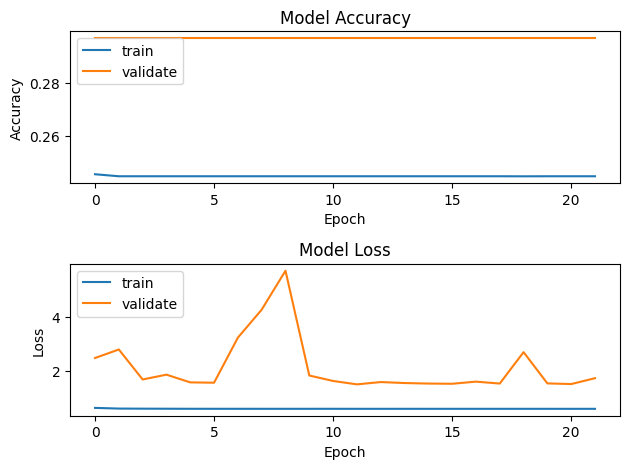

In [279]:
#Step 8: Display performance metrics:
def display_metrics(history):
  fig, axs = plt.subplots(2)

  # summarize history for accuracy
  axs[0].plot(history.history['accuracy'])
  axs[0].plot(history.history['val_accuracy'])
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'validate'], loc='upper left')

  # summarize history for loss
  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'validate'], loc='upper left')

  plt.tight_layout()
  plt.show()

display_metrics(history)

In [280]:
#And when you want to load your saved best model, use:
from keras.models import load_model
import keras.backend as K # Import keras backend

# Define the f1_m function if it's a custom metric
def f1_m(y_true, y_pred):
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Load the model with custom objects
best_model = load_model('best_model.hdf5', custom_objects={'f1_m': f1_m})

In [281]:
# Load your new data into an array and reshape
df_new_data = df_to_test[list(selected_features_names)]
df_new_data = np.reshape(df_new_data.values, (df_new_data.shape[0], df_new_data.shape[1], 1))

In [282]:
# Make Predictions
new_data_predictions = best_model.predict(df_new_data)

192/192 [==============================] - 4s 14ms/step


In [283]:
new_data_predictions

array([[0.264479  , 0.08348054, 0.65204036],
       [0.2644568 , 0.08345854, 0.6520846 ],
       [0.26442552, 0.08342598, 0.65214854],
       ...,
       [0.26133126, 0.08009483, 0.65857387],
       [0.2613047 , 0.08006179, 0.6586334 ],
       [0.26135245, 0.08011781, 0.65852976]], dtype=float32)

In [284]:
# Map your class labels to the class names
class_dict = {0: 'class_0', 1: 'class_1', 2: 'class_2'}

# Identify the most probable class
predicted_class = np.argmax(new_data_predictions, axis=1)

# Map the numeric labels to the class labels
predicted_class_labels = [class_dict[i] for i in predicted_class]

In [285]:
predicted_class

array([2, 2, 2, ..., 2, 2, 2])

In [286]:
# Last five predicted classes
#last_five_predicted_class = predicted_class[-5:]
last_five_predicted_class = predicted_class[-15:]

# Map the numeric labels to class labels
last_five_predicted_class_labels = [class_dict[i] for i in last_five_predicted_class]
print(last_five_predicted_class_labels)

['class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2', 'class_2']


# Xgboost - Class 1

In [266]:
#Xgboost

import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from collections import Counter

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Calculate class distribution in the training data
class_counts = Counter(Y_train_cv)
total_samples = len(Y_train_cv)

# Compute initial class weights based on their frequencies
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}

# Adjust the class weights according to the importance
class_weights[0] = 0.5  # Class 0
class_weights[1] = 1  # Class 1
class_weights[2] = 0.5  # Class 2

# Create sample weights for each sample in the training set
sample_weights = np.array([class_weights[cls] for cls in Y_train_cv])

# Initialize an XGBClassifier without class weights
clf = xgb.XGBClassifier()

# Set up possible parameters to randomly sample from
param_test = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(80, 100),
    'max_depth': sp_randint(3, 10),  # Note: XGB's max_depth values are usually lower
    'min_child_weight': sp_randint(1, 30),
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0],
    'reg_lambda': [0.1],
}

# A dictionary of the metrics of interest
scoring = {'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro', 'roc_auc_ovr': 'roc_auc_ovr'}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_test,
                                   n_iter=5, scoring=scoring, cv=tscv, refit='roc_auc_ovr',
                                   random_state=314, verbose=True)

# Fit randomized_search. Use X_train_cv_final and Y_train_cv with sample weights
random_search.fit(X_train_cv_final, Y_train_cv, sample_weight=sample_weights)

# Get the best parameters from the RandomizedSearchCV and print
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Create a new classifier using the best parameters from the RandomizedSearchCV
clf_1 = xgb.XGBClassifier(**best_params)

inner_cv = TimeSeriesSplit(n_splits=8)
outer_cv = TimeSeriesSplit(n_splits=5)

# Nested CV with parameter optimization
nested_score = cross_val_score(clf_1, X=X_train_cv_final, y=Y_train_cv, cv=outer_cv, fit_params={'sample_weight': sample_weights})
print("Nested CV score: ", nested_score.mean())

# Train a new model on the whole training set using the best parameters found and sample weights
clf_1.fit(X_train_cv_final, Y_train_cv, sample_weight=sample_weights)

# Test the trained model on the unseen test set
predictions = clf_1.predict(X_validation_final)
print(predictions)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'colsample_bytree': 0.9508006375244629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 23, 'n_estimators': 87, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.4083843394719862}
Nested CV score:  0.499778331947908
[1 1 1 ... 1 1 1]


In [267]:
#proba & predict
y_test_pred_xg_proba_test = clf_1.predict_proba(df_to_test[list(selected_features_names)])
y_test_pred_xg_class_test = clf_1.predict(df_to_test[list(selected_features_names)])

In [268]:
#performance
accuracy_test = accuracy_score(df_to_test.target_multiclass, y_test_pred_xg_class_test)
print("Accuracy: %.2f%%" % (accuracy_test * 100.0))

Accuracy: 49.30%


In [269]:
# calculate log loss
logloss_test = log_loss(df_to_test.target_multiclass, y_test_pred_xg_proba_test)
print("Logloss: %.2f" % logloss_test)

Logloss: 1.07


In [270]:
test_xg=df_to_test.target_multiclass.to_frame().copy()
test_xg=df_to_test.copy()
test_xg["datetime"]=df_to_test.datetime
test_xg["set_type"]='test'


In [271]:
test_xg["class_0"] = y_test_pred_xg_proba_test[:, 0]
test_xg["class_1"] = y_test_pred_xg_proba_test[:, 1]
test_xg["class_2"] = y_test_pred_xg_proba_test[:, 2]

In [272]:
test_xg.tail(20)

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,...,volatility_10,volatility_20,volatility_50,ATR,datetime,target_multiclass,set_type,class_0,class_1,class_2
62089,1.10622,1.10769,1.107474,0.000758,1.108067,1.105036,0.00032,1.10623,1.10650,1.10534,...,0.000953,0.000758,0.001844,0.000914,2023-12-29 13:30:00,1.0,test,0.305044,0.455901,0.239055
62090,1.10764,1.10806,1.107389,0.000791,1.108154,1.104991,0.00105,1.10765,1.10623,1.10650,...,0.001074,0.000791,0.001716,0.000940,2023-12-29 14:00:00,0.0,test,0.207518,0.605376,0.187106
62091,1.10792,1.10801,1.107252,0.000837,1.108148,1.104799,-0.00143,1.10793,1.10765,1.10623,...,0.001138,0.000837,0.001611,0.001126,2023-12-29 14:30:00,1.0,test,0.215966,0.421771,0.362262
62092,1.10516,1.10588,1.107131,0.000868,1.108155,1.104683,-0.00216,1.10517,1.10793,1.10765,...,0.001055,0.000868,0.001509,0.001169,2023-12-29 15:00:00,0.0,test,0.210600,0.583697,0.205703
62093,1.10546,1.10556,1.107003,0.000933,1.108203,1.104469,-0.00120,1.10545,1.10517,1.10793,...,0.001118,0.000933,0.001421,0.001193,2023-12-29 15:30:00,2.0,test,0.189384,0.586795,0.223822
62094,1.10487,1.10587,1.106891,0.000948,1.108187,1.104395,0.00040,1.10487,1.10545,1.10517,...,0.001096,0.000948,0.001299,0.001219,2023-12-29 16:00:00,2.0,test,0.233725,0.533244,0.233031
62095,1.10558,1.10702,1.106882,0.000953,1.108207,1.104395,0.00195,1.10558,1.10487,1.10545,...,0.001060,0.000953,0.001298,0.001321,2023-12-29 16:30:00,2.0,test,0.258736,0.454404,0.286860
62096,1.10689,1.10764,1.106852,0.000989,1.108338,1.104381,0.00215,1.10686,1.10558,1.10487,...,0.001094,0.000989,0.001265,0.001306,2023-12-29 17:00:00,0.0,test,0.224751,0.552704,0.222545
62097,1.10747,1.10785,1.106741,0.001052,1.108369,1.104160,-0.00178,1.10749,1.10686,1.10558,...,0.001209,0.001052,0.001201,0.001436,2023-12-29 17:30:00,2.0,test,0.238565,0.397583,0.363852
62098,1.10473,1.10606,1.106625,0.001057,1.108303,1.104074,-0.00083,1.10472,1.10749,1.10686,...,0.001235,0.001057,0.001026,0.001479,2023-12-29 18:00:00,2.0,test,0.244524,0.535337,0.220139


In [273]:
import pickle
filename = 'deaf_abrax_30m_xg_model.sav'
pickle.dump(clf_1, open(filename, 'wb'))

## 2. Regression Target:

Create a continuous target column that represents the actual pip change in the next 30-minute interval.

In [ ]:
#In this example, the 'target' column contains the actual pip change between the current close price and the close price of the next 30-minute interval.
df['target_reg'] = (df['close'].shift(-1) - df['close']) * 10000

## 3. Directional Target:

Create a target column that indicates the direction of the price movement (up, down, or no change) based on the pip change.

In [ ]:
#In this example, the 'target' column is set to 1 if the price increased by more than 4 pips, -1 if the price decreased by more than 10 pips, and 0 if the price change is within ±10 pips.
df['target_dir'] = np.where((df['close'].shift(-1) - df['close']) > (4 / 10000), 1,
                        np.where((df['close'].shift(-1) - df['close']) < (-4 / 10000), -1, 0))

In [ ]:
#drop NaN
df = df.dropna().copy()

In [ ]:
df.head(5)

,datetime,open,high,low,close,tick_volume,spread,real_volume,target_multiclass,target_reg,target_dir
0,2019-01-02 10:00:00,1.14764,1.14779,1.14493,1.14532,3177,2,0,0.0,-5.2,-1
2,2019-01-02 11:00:00,1.14480,1.14497,1.14356,1.14371,2643,2,0,1.0,-3.2,0
3,2019-01-02 11:30:00,1.14372,1.14420,1.14221,1.14339,2460,2,0,2.0,3.4,0
4,2019-01-02 12:00:00,1.14339,1.14380,1.14319,1.14373,2227,2,0,1.0,-0.4,0
5,2019-01-02 12:30:00,1.14373,1.14417,1.14353,1.14369,1813,2,0,1.0,-3.7,0


# SUPER LEARNER EXAMPLE


In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [ ]:
filename_xg = 'xg_model_signed_target_Q1.sav'
filename_cb = 'cb_model_signed_target_Q2.sav'
filename_lg = 'lg_model_signed_target_Q3.sav'
filename_hist = 'hist_model_signed_target_Q4.sav'
filename_hist_95 = 'hist_model95_signed_target.sav'
filename_lg_95 = 'lg95_model_signed_target.sav'

In [ ]:
#load train models
best_xgboost = pickle.load(open(filename_xg, 'rb'))
best_catboost = pickle.load(open(filename_cb, 'rb'))
best_lightgbm = pickle.load(open(filename_lg, 'rb'))
best_hist_gradient = pickle.load(open(filename_hist, 'rb'))
best_hist_gradient_95 = pickle.load(open(filename_hist_95, 'rb'))
best_lightgbm_95 = pickle.load(open(filename_lg_95, 'rb'))

In [ ]:
selected_feature_names = [
        'topWick',
        'body',
        'bottomWick',
        'spread',
        'hour',
        'day',
        'month',
        'body_3',
        'body_5',
        'body_20',
        'ticks_2',
        'ticks_4',
        'ticks_5',
        'ticks_15',
        'ticks_60',
        'spread_5',
        'spread_log',
        'body_log',
        'ticks_log',
        'spread_sqrt',
        'body_sqrt',
]

## Define X,y

In [ ]:
#Train/Valid/Test
X_train = df_22_23[(df_22_23["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_22_23["timestamp_column"]<="2022-12-30 16:43:37")]
#df_test = df_to_model[(df_to_model["datetime"]>("2023-10-31 23:57:50")) & (df_to_model["datetime"]<="2023-12-08 23:29:17")]

In [ ]:
print(X_train.shape)
print(df_test.shape)

(11652765, 13)
(721857, 24)


In [ ]:
print(X_train.timestamp_column.head(1))
print(X_train.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
11652764   2022-12-30 16:43:37
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: create new featires from datetime variable
X_train['hour'] = X_train['timestamp_column'].apply(lambda x: x.hour)
X_train['day'] = X_train['timestamp_column'].apply(lambda x: x.day)
X_train['month'] = X_train['timestamp_column'].apply(lambda x: x.month)

<ipython-input-54-5740a3da6662>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['hour'] = X_train['timestamp_column'].apply(lambda x: x.hour)
<ipython-input-54-5740a3da6662>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day'] = X_train['timestamp_column'].apply(lambda x: x.day)
<ipython-input-54-5740a3da6662>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
# prompt: create lags from body, ticks and spead features
X_train['body_1'] = X_train['body'].shift(one_min)
X_train['body_2'] = X_train['body'].shift(two_min)
X_train['body_3'] = X_train['body'].shift(three_min)
X_train['body_4'] = X_train['body'].shift(four_min)
X_train['body_5'] = X_train['body'].shift(five_min)
X_train['body_10'] = X_train['body'].shift(ten_min)
X_train['body_15'] = X_train['body'].shift(fifteen_min)
X_train['body_20'] = X_train['body'].shift(twenty_min)
X_train['body_25'] = X_train['body'].shift(twentyfive_min)
X_train['body_30'] = X_train['body'].shift(thirty_min)
X_train['body_40'] = X_train['body'].shift(fourty_min)
X_train['body_60'] = X_train['body'].shift(sixty_min)

<ipython-input-55-dd426b35e270>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_1'] = X_train['body'].shift(one_min)
<ipython-input-55-dd426b35e270>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_2'] = X_train['body'].shift(two_min)
<ipython-input-55-dd426b35e270>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
#for ticks
X_train['ticks_1'] = X_train['ticks'].shift(one_min)
X_train['ticks_2'] = X_train['ticks'].shift(two_min)
X_train['ticks_3'] = X_train['ticks'].shift(three_min)
X_train['ticks_4'] = X_train['ticks'].shift(four_min)
X_train['ticks_5'] = X_train['ticks'].shift(five_min)
X_train['ticks_10'] = X_train['ticks'].shift(ten_min)
X_train['ticks_15'] = X_train['ticks'].shift(fifteen_min)
X_train['ticks_20'] = X_train['ticks'].shift(twenty_min)
X_train['ticks_25'] = X_train['ticks'].shift(twentyfive_min)
X_train['ticks_30'] = X_train['ticks'].shift(thirty_min)
X_train['ticks_40'] = X_train['ticks'].shift(fourty_min)
X_train['ticks_60'] = X_train['ticks'].shift(sixty_min)

<ipython-input-56-1ffb8a0faada>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ticks_1'] = X_train['ticks'].shift(one_min)
<ipython-input-56-1ffb8a0faada>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ticks_2'] = X_train['ticks'].shift(two_min)
<ipython-input-56-1ffb8a0faada>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
#for spread
X_train['spread_1'] = X_train['spread'].shift(one_min)
X_train['spread_2'] = X_train['spread'].shift(two_min)
X_train['spread_3'] = X_train['spread'].shift(three_min)
X_train['spread_4'] = X_train['spread'].shift(four_min)
X_train['spread_5'] = X_train['spread'].shift(five_min)
X_train['spread_10'] = X_train['spread'].shift(ten_min)
X_train['spread_15'] = X_train['spread'].shift(fifteen_min)
X_train['spread_20'] = X_train['spread'].shift(twenty_min)
X_train['spread_25'] = X_train['spread'].shift(twentyfive_min)
X_train['spread_30'] = X_train['spread'].shift(thirty_min)
X_train['spread_40'] = X_train['spread'].shift(fourty_min)
X_train['spread_60'] = X_train['spread'].shift(sixty_min)

<ipython-input-57-e135a5abdc8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_1'] = X_train['spread'].shift(one_min)
<ipython-input-57-e135a5abdc8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_2'] = X_train['spread'].shift(two_min)
<ipython-input-57-e135a5abdc8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
X_train['spread_log'] = np.log(X_train['spread']+1)
X_train['body_log'] = np.log(X_train['body']+1)
X_train['ticks_log'] = np.log(X_train['ticks']+1)

<ipython-input-58-5c3f501d5056>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_log'] = np.log(X_train['spread']+1)
<ipython-input-58-5c3f501d5056>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_log'] = np.log(X_train['body']+1)
<ipython-input-58-5c3f501d5056>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
# prompt: Interaction Terms
X_train['spread_x_body'] = X_train['spread'] * X_train['body']
X_train['spread_x_ticks'] = X_train['spread'] * X_train['ticks']
X_train['body_x_ticks'] = X_train['body'] * X_train['ticks']

<ipython-input-59-51b2404b461c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_x_body'] = X_train['spread'] * X_train['body']
<ipython-input-59-51b2404b461c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_x_ticks'] = X_train['spread'] * X_train['ticks']
<ipython-input-59-51b2404b461c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
X_train['spread_sqrt'] = np.sqrt(X_train['spread'])
X_train['body_sqrt'] = np.sqrt(X_train['body'])
X_train['ticks_sqrt'] = np.sqrt(X_train['ticks'])

<ipython-input-60-f1a13caadcd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_sqrt'] = np.sqrt(X_train['spread'])
<ipython-input-60-f1a13caadcd2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_sqrt'] = np.sqrt(X_train['body'])
<ipython-input-60-f1a13caadcd2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
X_train_ = X_train.dropna()
holdout = df_test.dropna()

In [ ]:
X_train_.columns

Index(['timestamp_column', 'open', 'high', 'low', 'close', 'ticks', 'spread',
       'topWick', 'body', 'bottomWick', 'Y_5_log_1', 'Y_5', 'signed_sqrt_Y_5',
       'hour', 'day', 'month', 'body_1', 'body_2', 'body_3', 'body_4',
       'body_5', 'body_10', 'body_15', 'body_20', 'body_25', 'body_30',
       'body_40', 'body_60', 'ticks_1', 'ticks_2', 'ticks_3', 'ticks_4',
       'ticks_5', 'ticks_10', 'ticks_15', 'ticks_20', 'ticks_25', 'ticks_30',
       'ticks_40', 'ticks_60', 'spread_1', 'spread_2', 'spread_3', 'spread_4',
       'spread_5', 'spread_10', 'spread_15', 'spread_20', 'spread_25',
       'spread_30', 'spread_40', 'spread_60', 'spread_log', 'body_log',
       'ticks_log', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks',
       'spread_sqrt', 'body_sqrt', 'ticks_sqrt'],
      dtype='object')

In [ ]:
# Convert the index to datetime, if it is not already
X_train_.index = pd.to_datetime(X_train_.index)

In [ ]:
# Sort the dataframe based on the timestamp
X_train_ = X_train_.sort_index()

In [ ]:
# Set a seed for reproducibility (optional)
random_seed = 42
pd.np.random.seed(random_seed)

<ipython-input-65-379dc831544a>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.random.seed(random_seed)


In [ ]:
# Specify the desired sample percentage
sample_percentage = 0.3  # % of the data

In [ ]:
# Calculate the sample size as a percentage of the total number of rows
sample_size = int(len(X_train_) * sample_percentage)

In [ ]:
# Take a random sample of the dataframe while preserving the time sequence
X2 = X_train_.sample(n=sample_size)
print(X2.shape)

(3494749, 61)


In [ ]:
# Sort the sampled dataframe based on the timestamp (optional, but recommended)
X2 = X2.sort_index()

In [ ]:
print(X2.timestamp_column.head(1))
print(X2.timestamp_column.tail(1))

1970-01-01   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011649164   2022-12-30 15:28:57
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
X = X2[selected_feature_names].values
print(X.shape)
y = X2['signed_sqrt_Y_5'].values
print(y.shape)

(3494749, 21)
(3494749,)


## SL - Train Model

In [ ]:
# Step 1: Select a k-fold split of the training dataset
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Step 2: Select m base-models or model configurations
m = 2
base_models = [best_xgboost,best_catboost,best_lightgbm, best_hist_gradient, best_lightgbm_95,best_hist_gradient_95]

In [ ]:
# Step 3: For each basemodel
oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions

for i, model in enumerate(base_models):
    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model

    # Step 3a: Evaluate using k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cloned_model = clone(model)  # Create a fresh clone of the model
        cloned_model.fit(X_train, y_train)  # Fit the model on the training set

        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold

    # Step 3b: Store all out-of-fold predictions
    oof_preds[:, i] = oof_model_preds

    # Step 3c: Fit the model on the full training dataset and store
    model.fit(X, y)

# Step 4: Fit a meta-model on the out-of-fold predictions
meta_model = LGBMRegressor(
    learning_rate=1.3,
    max_depth=8,
    num_leaves=100,
    min_child_samples=5
)
meta_model.fit(oof_preds, y)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.9918648	total: 460ms	remaining: 3m 49s
1:	learn: 1.9867389	total: 790ms	remaining: 3m 16s
2:	learn: 1.9826873	total: 1.12s	remaining: 3m 6s
3:	learn: 1.9793065	total: 1.46s	remaining: 3m 1s
4:	learn: 1.9764352	total: 1.81s	remaining: 2m 58s
5:	learn: 1.9742771	total: 2.15s	remaining: 2m 56s
6:	learn: 1.9714519	total: 2.5s	remaining: 2m 56s
7:	learn: 1.9693666	total: 2.87s	remaining: 2m 56s
8:	learn: 1.9682121	total: 3.22s	remaining: 2m 55s
9:	learn: 1.9660681	total: 3.54s	remaining: 2m 53s
10:	learn: 1.9642568	total: 3.9s	remaining: 2m 53s
11:	learn: 1.9636939	total: 4.21s	remaining: 2m 51s
12:	learn: 1.9621192	total: 4.52s	remaining: 2m 49s
13:	learn: 1.9602461	total: 4.83s	remaining: 2m 47s
14:	learn: 1.9588162	total: 5.14s	remaining: 2m 46s
15:	learn: 1.9571012	total: 5.44s	remaining: 2m 44s
16:	learn: 1.9557646	total: 5.74s	remaining: 2m 43s
17:	learn: 1.9543028	total: 6.02s	remaining: 2m 41s
18:	learn: 1.9529556	total: 6.32s	remaining: 2m 39s
19:	learn: 1.9516812	total

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.9920819	total: 318ms	remaining: 2m 38s
1:	learn: 1.9866650	total: 618ms	remaining: 2m 34s
2:	learn: 1.9828288	total: 889ms	remaining: 2m 27s
3:	learn: 1.9794391	total: 1.19s	remaining: 2m 27s
4:	learn: 1.9769981	total: 1.49s	remaining: 2m 27s
5:	learn: 1.9748572	total: 1.79s	remaining: 2m 27s
6:	learn: 1.9716422	total: 2.07s	remaining: 2m 26s
7:	learn: 1.9699252	total: 2.38s	remaining: 2m 26s
8:	learn: 1.9679203	total: 2.71s	remaining: 2m 28s
9:	learn: 1.9660741	total: 3.04s	remaining: 2m 29s
10:	learn: 1.9636699	total: 3.38s	remaining: 2m 30s
11:	learn: 1.9627369	total: 3.72s	remaining: 2m 31s
12:	learn: 1.9603111	total: 4.07s	remaining: 2m 32s
13:	learn: 1.9579889	total: 4.43s	remaining: 2m 33s
14:	learn: 1.9562794	total: 4.8s	remaining: 2m 35s
15:	learn: 1.9546859	total: 5.16s	remaining: 2m 36s
16:	learn: 1.9525995	total: 5.52s	remaining: 2m 36s
17:	learn: 1.9519037	total: 5.86s	remaining: 2m 36s
18:	learn: 1.9503068	total: 6.16s	remaining: 2m 35s
19:	learn: 1.9483099	to

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.9907610	total: 317ms	remaining: 2m 38s
1:	learn: 1.9867114	total: 613ms	remaining: 2m 32s
2:	learn: 1.9830348	total: 907ms	remaining: 2m 30s
3:	learn: 1.9802963	total: 1.21s	remaining: 2m 29s
4:	learn: 1.9771022	total: 1.52s	remaining: 2m 30s
5:	learn: 1.9748991	total: 1.82s	remaining: 2m 30s
6:	learn: 1.9723556	total: 2.12s	remaining: 2m 29s
7:	learn: 1.9708215	total: 2.43s	remaining: 2m 29s
8:	learn: 1.9681572	total: 2.72s	remaining: 2m 28s
9:	learn: 1.9657443	total: 3s	remaining: 2m 27s
10:	learn: 1.9647739	total: 3.31s	remaining: 2m 26s
11:	learn: 1.9628453	total: 3.6s	remaining: 2m 26s
12:	learn: 1.9612479	total: 3.9s	remaining: 2m 26s
13:	learn: 1.9587853	total: 4.22s	remaining: 2m 26s
14:	learn: 1.9565119	total: 4.57s	remaining: 2m 27s
15:	learn: 1.9553733	total: 4.92s	remaining: 2m 28s
16:	learn: 1.9534026	total: 5.25s	remaining: 2m 29s
17:	learn: 1.9514869	total: 5.58s	remaining: 2m 29s
18:	learn: 1.9496272	total: 5.91s	remaining: 2m 29s
19:	learn: 1.9480931	total:

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.9910428	total: 450ms	remaining: 3m 44s
1:	learn: 1.9862200	total: 861ms	remaining: 3m 34s
2:	learn: 1.9816536	total: 1.29s	remaining: 3m 33s
3:	learn: 1.9780232	total: 1.73s	remaining: 3m 34s
4:	learn: 1.9756887	total: 2.14s	remaining: 3m 31s
5:	learn: 1.9729704	total: 2.58s	remaining: 3m 32s
6:	learn: 1.9703879	total: 3.02s	remaining: 3m 32s
7:	learn: 1.9683358	total: 3.46s	remaining: 3m 32s
8:	learn: 1.9667572	total: 3.87s	remaining: 3m 31s
9:	learn: 1.9646585	total: 4.33s	remaining: 3m 32s
10:	learn: 1.9624760	total: 4.76s	remaining: 3m 31s
11:	learn: 1.9607997	total: 5.15s	remaining: 3m 29s
12:	learn: 1.9594727	total: 5.59s	remaining: 3m 29s
13:	learn: 1.9580493	total: 6s	remaining: 3m 28s
14:	learn: 1.9560116	total: 6.45s	remaining: 3m 28s
15:	learn: 1.9542807	total: 6.88s	remaining: 3m 28s
16:	learn: 1.9527756	total: 7.38s	remaining: 3m 29s
17:	learn: 1.9516751	total: 7.88s	remaining: 3m 30s
18:	learn: 1.9504077	total: 8.33s	remaining: 3m 30s
19:	learn: 1.9490987	tota

LGBMRegressor(learning_rate=1.3, max_depth=8, min_child_samples=5,
              num_leaves=100)

In [ ]:
# Step 3: For each basemodel
#oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions
#
#for i, model in enumerate(base_models):
#    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model
#
#    # Step 3a: Evaluate using k-fold cross-validation
#    for train_index, val_index in kf.split(X, y):
#        X_train, X_val = X[train_index], X[val_index]
#        y_train, y_val = y[train_index], y[val_index]
#
#        cloned_model = clone(model)  # Create a fresh clone of the model
#        cloned_model.fit(X_train, y_train)  # Fit the model on the training set
#
#        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
#        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold
#
#    # Step 3b: Store all out-of-fold predictions
#    oof_preds[:, i] = oof_model_preds
#
#    # Step 3c: Fit the model on the full training dataset and store
#    model.fit(X, y)
#
## Step 4: Fit a meta-model on the out-of-fold predictions
#from sklearn.ensemble import HistGradientBoostingRegressor
#meta_model = HistGradientBoostingRegressor(
#    learning_rate=0.1,
#    max_depth=8,
#    max_iter=100,
#    l2_regularization=0.1,
#    min_samples_leaf=10,
#    max_leaf_nodes=100,
#    early_stopping=True
#)
#meta_model.fit(oof_preds, y)

0:	learn: 5.3391067	total: 313ms	remaining: 2m 36s
1:	learn: 5.3049098	total: 630ms	remaining: 2m 36s
2:	learn: 5.2694616	total: 958ms	remaining: 2m 38s
3:	learn: 5.2371496	total: 1.29s	remaining: 2m 39s
4:	learn: 5.2198834	total: 1.6s	remaining: 2m 38s
5:	learn: 5.1993347	total: 1.9s	remaining: 2m 36s
6:	learn: 5.1872012	total: 2.21s	remaining: 2m 35s
7:	learn: 5.1698633	total: 2.54s	remaining: 2m 35s
8:	learn: 5.1574570	total: 2.86s	remaining: 2m 36s
9:	learn: 5.1528693	total: 3.19s	remaining: 2m 36s
10:	learn: 5.1376750	total: 3.47s	remaining: 2m 34s
11:	learn: 5.1291692	total: 3.77s	remaining: 2m 33s
12:	learn: 5.1192017	total: 4.09s	remaining: 2m 33s
13:	learn: 5.1109213	total: 4.39s	remaining: 2m 32s
14:	learn: 5.1032341	total: 4.74s	remaining: 2m 33s
15:	learn: 5.0963830	total: 5.13s	remaining: 2m 35s
16:	learn: 5.0885491	total: 5.49s	remaining: 2m 35s
17:	learn: 5.0803972	total: 5.84s	remaining: 2m 36s
18:	learn: 5.0723524	total: 6.14s	remaining: 2m 35s
19:	learn: 5.0681065	tot

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=1.0,
                              max_depth=8, max_leaf_nodes=100,
                              min_samples_leaf=10)

In [ ]:
holdout_X = holdout[selected_feature_names].values

In [ ]:
holdout_X

array([[2.        , 0.        , 0.        , ..., 2.07944154, 3.46410162,
        0.        ],
       [0.        , 4.        , 0.        , ..., 1.94591015, 3.16227766,
        2.        ],
       [0.        , 2.        , 0.        , ..., 1.09861229, 1.41421356,
        1.41421356],
       ...,
       [0.        , 0.        , 0.        , ..., 1.38629436, 2.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 1.09861229, 1.73205081,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.69314718, 1.41421356,
        0.        ]])

In [ ]:
# Step 5: Evaluate the model on a holdout dataset or use model to make predictions
holdout_preds = np.zeros((holdout_X.shape[0], len(base_models)))  # Store predictions on holdout dataset

for i, model in enumerate(base_models):
    holdout_preds[:, i] = model.predict(holdout_X)

final_preds = meta_model.predict(holdout_preds)

# Evaluate the performance or use final_preds for further analysis

In [ ]:
final_preds.shape

(721857,)

## Validations

In [ ]:
# Split the data into training, hold-out validation, and test sets
X_train, X_holdout, y_train, y_holdout = train_test_split(oof_preds, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# Train the meta-model on the training set
meta_model.fit(X_train, y_train)

# Tune hyperparameters using the hold-out validation set
val_preds = meta_model.predict(X_val)

# Evaluate the performance on the hold-out validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

# Make predictions on the test set
test_preds = meta_model.predict(X_test)

# Evaluate the performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, max_iter=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2795799, number of used features: 4
[LightGBM] [Info] Start training from score -0.016431


In [ ]:
val_rmse

1.9322593286178864

In [ ]:
test_rmse

1.9405411654713385

# ***Save meta-model***

In [ ]:
filename = 'meta_hist_4_models_signed_target_p95.sav'
pickle.dump(meta_model, open(filename, 'wb'))

In [ ]:
# Step 6: Save the trained meta-model
#joblib.dump(meta_model, "meta_model.pkl")

In [ ]:
#predictions stored in separate variables
preds_base_model1 = result_test_xg['pred_test_xb'].values
preds_base_model2 = result_test_cb['pred_test_cb'].values
preds_base_model3 = result_test_lg['pred_test_lg'].values
preds_base_model4 = result_test_hist['pred_test_hist'].values
#preds_base_model5 = result_test_svr['pred_test_svr'].values
#preds_base_model6 = result_test_knn['pred_test_knn'].values
#preds_base_model7 = result_test_ada['pred_test_ada'].values
#preds_base_model8 = result_test_bagg['pred_test_bagg'].values
#preds_base_model9 = result_test_extr['pred_test_extr'].values

NameError: name 'result_test_xg' is not defined

In [ ]:
preds_base_model3.shape

(809032,)

In [ ]:
# Create a dictionary to store the predictions
data = {
    'pred_model1': preds_base_model1,
    'pred_model2': preds_base_model2,
    'pred_model3': preds_base_model3,
    'pred_model4': preds_base_model4,
    #'pred_model5': preds_base_model5,
    #'pred_model6': preds_base_model6,
    #'pred_model7': preds_base_model7,
    #'pred_model8': preds_base_model8,
    #'pred_model9': preds_base_model9,
    'pred_meta_model': final_preds
}

In [ ]:
# Create a dataframe from the dictionary
predictions_df = pd.DataFrame(data)

In [ ]:
predictions_df.head(100)

,pred_model1,pred_model2,pred_model3,pred_model4,pred_meta_model
0,1.390460,-0.304786,0.043982,-2.013114,0.131867
1,-0.994009,-2.471739,-0.187381,-0.428108,-0.946374
2,1.863811,-0.136881,0.462876,0.335625,-0.939715
3,1.754616,-1.048803,-0.265536,-1.054676,-0.689878
4,2.859775,-1.914300,0.440369,-0.982299,-1.698105
...,...,...,...,...,...
95,0.624932,0.312021,-1.663238,-0.168416,-1.250500
96,1.981028,-0.808473,0.336584,-0.435076,-0.888308
97,1.846411,0.120422,0.497640,-0.051576,-1.691997
98,0.534561,-0.159806,0.313407,-0.214239,-0.488544


In [ ]:
# prompt: count negative vallues in each variable in predictions_df
print(predictions_df[predictions_df > 0].count(), "positive tendence")
print(predictions_df[predictions_df < 0].count(), "negative tendence")


pred_model1        378547
pred_model2        392886
pred_model3        385041
pred_model4        381290
pred_meta_model    414477
dtype: int64 positive tendence
pred_model1        430485
pred_model2        416146
pred_model3        423991
pred_model4        427742
pred_meta_model    394555
dtype: int64 negative tendence


# In Production

In [ ]:
#!pip install ta
#!pip install catboost
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
# Import XGBoost
from xgboost import XGBRegressor
# Import CatBoost
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_absolute_percentage_error
from google.colab import data_table
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import time
import joblib
data_table.enable_dataframe_formatter()


In [ ]:
filename_xg = 'xg_model_signed_target_Q1.sav'
filename_cb = 'cb_model_signed_target_Q2.sav'
filename_lg = 'lg_model_signed_target_Q3.sav'
filename_hist = 'hist_model_signed_target_Q4.sav'
filename_hist_95 = 'hist_model95_signed_target.sav'
filename_lg_95 = 'lg95_model_signed_target.sav'
filename_meta = 'meta_hist_4_models_signed_target_p95.sav'

In [ ]:
#load train models
best_xgboost = pickle.load(open(filename_xg, 'rb'))
best_catboost = pickle.load(open(filename_cb, 'rb'))
best_lightgbm = pickle.load(open(filename_lg, 'rb'))
best_hist_gradient = pickle.load(open(filename_hist, 'rb'))
best_hist_gradient_95 = pickle.load(open(filename_hist_95, 'rb'))
best_lightgbm_95 = pickle.load(open(filename_lg_95, 'rb'))
meta_model = pickle.load(open(filename_meta, 'rb'))

In [ ]:
selected_feature_names = [
    'topWick',
    'body',
    'bottomWick',
    'spread',
    'hour',
    'day',
    'month',
    'body_3',
    'body_5',
    'body_20',
    'ticks_2',
    'ticks_4',
    'ticks_5',
    'ticks_15',
    'ticks_60',
    'spread_5',
    'spread_log',
    'body_log',
    'ticks_log',
    'spread_sqrt',
    'body_sqrt'
]

In [ ]:
def feature_engineering(data):
    # Perform the same feature engineering steps as before using the provided dataset
    one_min = -60
    two_min = -120
    three_min = -180
    four_min = -240
    five_min = -300
    ten_min = -600
    fifteen_min = -900
    twenty_min = -1200
    twentyfive_min = -1500
    thirty_min = -1800
    fourty_min = -2400
    sixty_min = -3600

    #add the remaining feature engineering steps using the provided dataset
    data['hour'] = data['timestamp_column'].apply(lambda x: x.hour)
    data['day'] = data['timestamp_column'].apply(lambda x: x.day)
    data['month'] = data['timestamp_column'].apply(lambda x: x.month)
    data['body_3'] = data['body'].shift(three_min)
    data['body_5'] = data['body'].shift(five_min)
    data['body_20'] = data['body'].shift(twenty_min)
    data['ticks_2'] = data['ticks'].shift(two_min)
    data['ticks_4'] = data['ticks'].shift(four_min)
    data['ticks_5'] = data['ticks'].shift(five_min)
    data['ticks_15'] = data['ticks'].shift(fifteen_min)
    data['ticks_60'] = data['ticks'].shift(sixty_min)
    data['spread_5'] = data['spread'].shift(five_min)
    data['spread_log'] = np.log(data['spread']+1)
    data['body_log'] = np.log(data['body']+1)
    data['ticks_log'] = np.log(data['ticks']+1)
    data['spread_sqrt'] = np.sqrt(data['spread'])
    data['body_sqrt'] = np.sqrt(data['body'])

    return data[selected_feature_names]  # Return only the selected features

In [ ]:
# Create the pipeline incorporating the feature engineering function.
pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(feature_engineering)),
])

In [ ]:
#df_22_23 = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/df_22_23.csv',low_memory=False,delimiter=',',header=0)

In [ ]:
#print(df_22_23.shape)

In [ ]:
#df_22_23[df_22_23['timestamp_column']] = pd.to_datetime(df_22_23['timestamp_column'])

In [ ]:
print(df_full_2023.head(1))
print(df_full_2023.tail(1))

     timestamp_column direction  topWick  body  bottomWick  ticks  spread  \
0 2023-01-03 05:42:41       'D'        0     1           0      2       9   

      open     high      low    close  Y_5  
0  1.06749  1.06749  1.06748  1.06748 -2.4  
           timestamp_column direction  topWick  body  bottomWick  ticks  \
9811695 2023-12-08 23:59:56       'N'        0     0           0      1   

         spread     open     high      low    close  Y_5  
9811695      90  1.07596  1.07596  1.07596  1.07596  NaN  


In [ ]:
df_full_2023.isnull().sum()

timestamp_column      0
direction             0
topWick               0
body                  0
bottomWick            0
ticks                 0
spread                0
open                  0
high                  0
low                   0
close                 0
Y_5                 300
dtype: int64

In [ ]:
df_full_2023['year'] = df_full_2023['timestamp_column'].apply(lambda x: x.year)
df_full_2023['month'] = df_full_2023['timestamp_column'].apply(lambda x: x.month)
df_full_2023['day'] = df_full_2023['timestamp_column'].apply(lambda x: x.day)

In [ ]:
# copy data to work with
df_analysis = df_full_2023.copy()

In [ ]:
year_ = 2023
month_ = 12
day_ = 29

In [ ]:
#df_jan_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_jan_.shape)
#df_feb_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_feb_.shape)
#df_mar_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_mar_.shape)
#df_apr_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_apr_.shape)
#df_may_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_may_.shape)
#df_jun_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_jun_.shape)
#df_jul_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_jul_.shape)
#df_aug_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_aug_.shape)
#df_sep_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_sep_.shape)
#df_oct_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_oct_.shape)
#df_nov_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
#print(df_nov_.shape)
df_dec_ = df_analysis[(df_analysis['year'] == year_) & (df_analysis['month'] == month_) & (df_analysis['day'] <= day_)]
print(df_dec_.shape)

(263968, 15)


In [ ]:
#new_data_variable = df_jan_.dropna().copy()
#new_data_variable = df_feb_.dropna().copy()
#new_data_variable = df_mar_.dropna().copy()
#new_data_variable = df_apr_.dropna().copy()
#new_data_variable = df_may_.dropna().copy()
#new_data_variable = df_jun_.dropna().copy()
#new_data_variable = df_jul_.dropna().copy()
#new_data_variable = df_aug_.dropna().copy()
#new_data_variable = df_sep_.dropna().copy()
#new_data_variable = df_oct_.dropna().copy()
#new_data_variable = df_nov_.dropna().copy()
new_data_variable = df_dec_.dropna().copy()

In [ ]:
print(new_data_variable.shape)

(263668, 15)


In [ ]:
#Process new datasets using the pipeline.
processed_data = pipeline.transform(new_data_variable)

In [ ]:
# Make predictions with each model
pred_model1 = best_xgboost.predict(processed_data)
pred_model2 = best_catboost.predict(processed_data)
pred_model3 = best_lightgbm.predict(processed_data)
pred_model4 = best_hist_gradient.predict(processed_data)
pred_model5 = best_hist_gradient_95.predict(processed_data)
pred_model6 = best_lightgbm_95.predict(processed_data)

In [ ]:
# Combine the predictions into a single array
base_model_preds = [pred_model1,pred_model2, pred_model3, pred_model4, pred_model5, pred_model6]
base_model_preds = np.array(base_model_preds).T

In [ ]:
# Make prediction with the meta-model
pred_meta_model = meta_model.predict(base_model_preds)

In [ ]:
# Create a dictionary to store the predictions
data_final_pred = {
    'timestamp_column': new_data_variable['timestamp_column'],
    'pred_model1': pred_model1,
    'pred_model2': pred_model2,
    'pred_model3': pred_model3,
    'pred_model4': pred_model4,
    'pred_model5': pred_model5,
    'pred_model6': pred_model6,
    'pred_meta_model': pred_meta_model
}

In [ ]:
# Create a dataframe from the dictionary
predictions_df = pd.DataFrame(data_final_pred)

In [ ]:
predictions_df.shape

(263668, 8)

In [ ]:
predictions_df.head(5)

,timestamp_column,pred_model1,pred_model2,pred_model3,pred_model4,pred_model5,pred_model6,pred_meta_model
9547728,2023-12-01 00:00:00,2.114755,-0.446320,-0.505542,-1.089918,-0.461682,1.869068,-0.413780
9547729,2023-12-01 00:00:44,1.268635,1.739049,0.705466,0.721350,0.264926,-1.313489,0.624413
9547730,2023-12-01 00:01:00,1.492761,2.020408,1.005854,1.504999,0.866456,-1.411955,1.213383
9547731,2023-12-01 00:01:30,3.026725,1.248536,1.542069,0.910193,2.695543,-0.153922,2.896585
9547732,2023-12-01 00:02:06,2.875376,1.208043,1.735372,1.529349,3.204127,-1.518621,2.750992


In [ ]:
month_describe = predictions_df

In [ ]:
# prompt: plot percentiles of pred_meta_model ans show values

#import matplotlib.pyplot as plt
#plt.figure(figsize=(10, 5))
#sns.boxplot(x=month_describe['pred_meta_model'])
#plt.xlabel('pred_meta_model')
#plt.ylabel('Value')
#plt.title('Percentiles of pred_meta_model for February_')
#plt.show()
#print(month_describe['pred_meta_model'].describe(percentiles=[0.7,0.75,0.8,0.85,0.90,0.95]).round(1))


In [ ]:
# prompt: filter in month_describe only when pred_meta_model >=3.5
filtered_month_describe = month_describe[(month_describe['pred_meta_model'] >= 3.5) | (month_describe['pred_meta_model'] <= -3.5)]

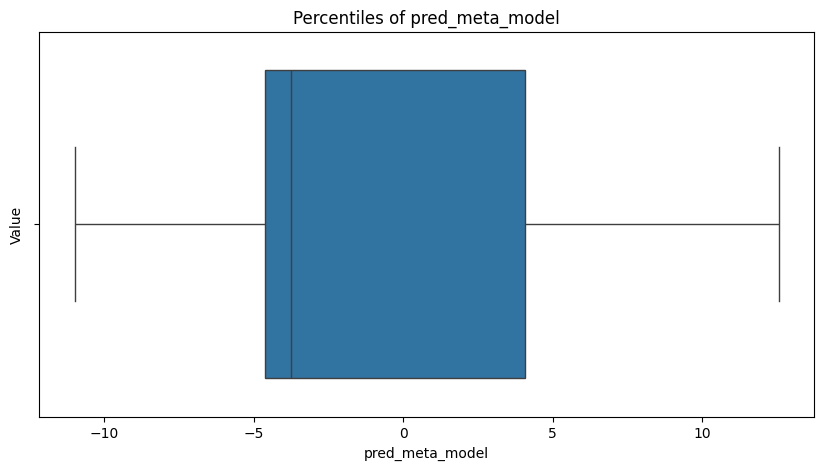

count    12133.0
mean        -0.9
std          4.7
min        -11.0
50%         -3.7
70%          3.9
75%          4.1
80%          4.4
85%          4.7
90%          5.1
95%          5.8
max         12.6
Name: pred_meta_model, dtype: float64


In [ ]:
# prompt: plot percentiles of pred_meta_model ans show values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.boxplot(x=filtered_month_describe['pred_meta_model'])
plt.xlabel('pred_meta_model')
plt.ylabel('Value')
plt.title('Percentiles of pred_meta_model')
plt.show()
print(filtered_month_describe['pred_meta_model'].describe(percentiles=[0.7,0.75,0.8,0.85,0.90,0.95]).round(1))

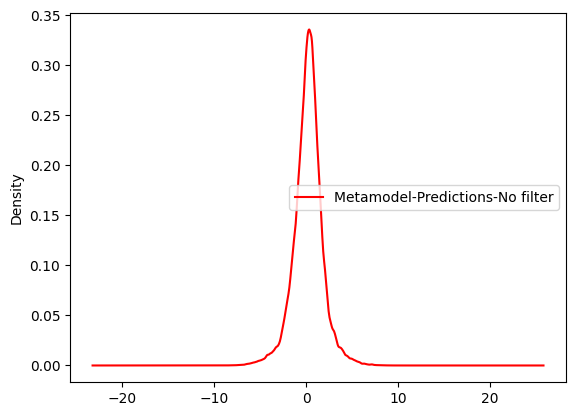

In [ ]:
month_describe["pred_meta_model"].plot.kde(label="Metamodel-Predictions-No filter",color='r')
plt.legend()

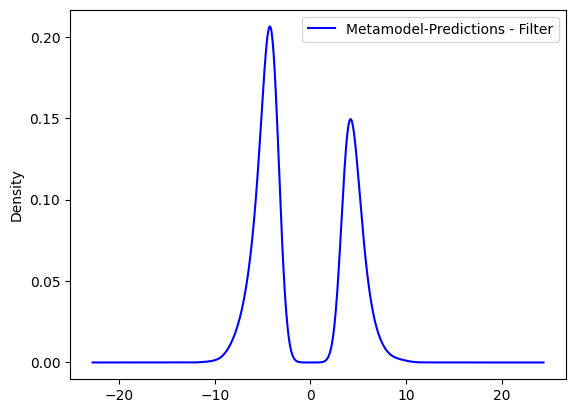

In [ ]:
filtered_month_describe["pred_meta_model"].plot.kde(label="Metamodel-Predictions - Filter",color='b')
plt.legend()